<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Sport-Vouchers-Program-Analysis" data-toc-modified-id="Sport-Vouchers-Program-Analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Sport Vouchers Program Analysis</a></span><ul class="toc-item"><li><span><a href="#Description-of-voucher-data:" data-toc-modified-id="Description-of-voucher-data:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Description of voucher data:</a></span></li><li><span><a href="#Description-of-seifa-data:" data-toc-modified-id="Description-of-seifa-data:-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Description of seifa data:</a></span></li><li><span><a href="#For-later-visualisation-purposes,-LGA-map-data-will-be-read-into-the-notebook" data-toc-modified-id="For-later-visualisation-purposes,-LGA-map-data-will-be-read-into-the-notebook-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>For later visualisation purposes, LGA map data will be read into the notebook</a></span></li></ul></li><li><span><a href="#Describe-the-distribution-of-vouchers-by:-LGA,-Sport---which-regions/sports-stand-out?" data-toc-modified-id="Describe-the-distribution-of-vouchers-by:-LGA,-Sport---which-regions/sports-stand-out?-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out?</a></span><ul class="toc-item"><li><span><a href="#By-LGA" data-toc-modified-id="By-LGA-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>By LGA</a></span></li><li><span><a href="#Findings-of-LGA-analysis:" data-toc-modified-id="Findings-of-LGA-analysis:-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Findings of LGA analysis:</a></span></li><li><span><a href="#By-Sports" data-toc-modified-id="By-Sports-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>By Sports</a></span></li><li><span><a href="#Findings-of-Sports-analysis:" data-toc-modified-id="Findings-of-Sports-analysis:-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Findings of Sports analysis:</a></span></li></ul></li><li><span><a href="#Are-some-sports-more-popular-in-different-parts-of-the-state?" data-toc-modified-id="Are-some-sports-more-popular-in-different-parts-of-the-state?-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Are some sports more popular in different parts of the state?</a></span><ul class="toc-item"><li><span><a href="#Findings:" data-toc-modified-id="Findings:-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Findings:</a></span></li><li><span><a href="#Plot-Voucher-distribution-on-Map" data-toc-modified-id="Plot-Voucher-distribution-on-Map-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Plot Voucher distribution on Map</a></span></li></ul></li><li><span><a href="#Are-any-LGAs-over/under-represented-in-their-use-of-vouchers?" data-toc-modified-id="Are-any-LGAs-over/under-represented-in-their-use-of-vouchers?-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Are any LGAs over/under represented in their use of vouchers?</a></span><ul class="toc-item"><li><span><a href="#Findings-of-LGA-analysis:" data-toc-modified-id="Findings-of-LGA-analysis:-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Findings of LGA analysis:</a></span></li></ul></li><li><span><a href="#Is-there-a-relationship-between-any-of-the-SEIFA-measures-and-voucher-use-in-an-LGA?" data-toc-modified-id="Is-there-a-relationship-between-any-of-the-SEIFA-measures-and-voucher-use-in-an-LGA?-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Is there a relationship between any of the SEIFA measures and voucher use in an LGA?</a></span><ul class="toc-item"><li><span><a href="#Conduct-univariate-analysis-of-variables" data-toc-modified-id="Conduct-univariate-analysis-of-variables-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Conduct univariate analysis of variables</a></span><ul class="toc-item"><li><span><a href="#ATSI" data-toc-modified-id="ATSI-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>ATSI</a></span></li><li><span><a href="#CALD" data-toc-modified-id="CALD-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>CALD</a></span></li><li><span><a href="#Sex" data-toc-modified-id="Sex-5.1.3"><span class="toc-item-num">5.1.3&nbsp;&nbsp;</span>Sex</a></span></li><li><span><a href="#IEO" data-toc-modified-id="IEO-5.1.4"><span class="toc-item-num">5.1.4&nbsp;&nbsp;</span>IEO</a></span></li><li><span><a href="#IER" data-toc-modified-id="IER-5.1.5"><span class="toc-item-num">5.1.5&nbsp;&nbsp;</span>IER</a></span></li><li><span><a href="#IRSAD" data-toc-modified-id="IRSAD-5.1.6"><span class="toc-item-num">5.1.6&nbsp;&nbsp;</span>IRSAD</a></span></li><li><span><a href="#IRSD" data-toc-modified-id="IRSD-5.1.7"><span class="toc-item-num">5.1.7&nbsp;&nbsp;</span>IRSD</a></span></li></ul></li><li><span><a href="#Conduct-bivariate-analysis-of-variables-with-target-variable" data-toc-modified-id="Conduct-bivariate-analysis-of-variables-with-target-variable-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Conduct bivariate analysis of variables with target variable</a></span></li></ul></li><li><span><a href="#Challenge---Queensland" data-toc-modified-id="Challenge---Queensland-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Challenge - Queensland</a></span></li></ul></div>

# Sport Vouchers Program Analysis

The goal of this Portfolio task is to explore data from the Federal Government Sport Vouchers program - this is a
program that provides up to two $100 vouchers for kids to participate in organised sport. Here's the [NSW Active Kids page](https://www.service.nsw.gov.au/transaction/apply-active-kids-voucher), there are similar schemes in other states - this data is from South Australia.

This is an exercise in exploring data and communicating the insights you can gain from it.  The source data comes
from the `data.gov.au` website and provides details of all Sport Vouchers that have been redeemed since February  in SA 2015 as part of the Sport Voucher program:  [Sports Vouchers Data](https://data.gov.au/dataset/ds-sa-14daba50-04ff-46c6-8468-9fa593b9f100/details).  This download is provided for you as `sportsvouchersclaimed.csv`.

To augment this data you can also make use of [ABS SEIFA data by LGA](http://stat.data.abs.gov.au/Index.aspx?DataSetCode=ABS_SEIFA_LGA#) which shows a few measures of Socioeconomic Advantage and Disadvantage for every Local Government Area. This data is provided for you as `ABS_SEIFA_LGA.csv`. This could enable you to answer questions about whether the voucher program is used equally by parents in low, middle and high socioeconomic areas.   You might be interested in this if you were concerned that this kind of program might just benifit parents who are already advantaged (they might already be paying for sport so this program wouldn't be helping much).

Questions:
* Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out? 
* Are some sports more popular in different parts of the state?
* Are any LGAs over/under represented in their use of vouchers?
* Is there a relationship between any of the SEIFA measures and voucher use in an LGA?

A challenge in this task is to display a useful summary of the data given that there are a large number of LGAs and sports involved.  Try to avoid long lists and large tables. Think about what plots and tables communicate the main points of your findings. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline

In [2]:
# read the sports vouchers data
sa_vouchers = pd.read_csv("files/sportsvouchersclaimed.csv")
sa_vouchers

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127521,1127524,ZADOWS LANDING,Registered Previously,Not ATSI,Not CALD,Female,50,Mannum Roos Netball Club,Netball,MID MURRAY,SCHUBERT,15/8/16 1:33,2016
127522,1127524,ZADOWS LANDING,Registered Previously,Not ATSI,Not CALD,Female,50,Mannum Roos Netball Club,Netball,MID MURRAY,SCHUBERT,13/7/15 23:42,2015
127523,1127524,ZADOWS LANDING,Registered Previously,Not ATSI,Not CALD,Female,50,Mannum Roos Netball Club,Netball,MID MURRAY,SCHUBERT,30/6/17 6:07,2017
127524,1127526,ZADOWS LANDING,Registered Previously,Not ATSI,Not CALD,Female,50,Mannum Roos Netball Club,Netball,MID MURRAY,SCHUBERT,28/4/15 0:06,2015


In [3]:
sa_vouchers[sa_vouchers['Participant_LGA'] == 'ADELAIDE PLAINS']

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year
6954,1006955,BARABBA,Not Registered Previously,Not ATSI,Not CALD,Male,50,S.A.N.F.L,Australian Rules,ADELAIDE PLAINS,GOYDER,30/3/17 0:46,2017
6955,1006956,BARABBA,Not Registered Previously,Not ATSI,Not CALD,Male,50,Mallala Football Club,Australian Rules,ADELAIDE PLAINS,GOYDER,14/9/15 5:20,2015
6956,1006957,BARABBA,Registered Previously,Not ATSI,Not CALD,Female,50,Mallala Netball Club,Netball,ADELAIDE PLAINS,GOYDER,30/3/17 0:37,2017
6957,1006960,BARABBA,Not Registered Previously,Not ATSI,Not CALD,Male,50,Hamley Bridge Football Club,Australian Rules,ADELAIDE PLAINS,GOYDER,28/8/15 2:28,2015
6958,1006960,BARABBA,Registered Previously,Not ATSI,Not CALD,Male,50,S.A.N.F.L,Australian Rules,ADELAIDE PLAINS,GOYDER,17/6/16 1:03,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123703,1123704,WINDSOR,Not Registered Previously,Not ATSI,Not CALD,Male,50,S.A.N.F.L,Australian Rules,ADELAIDE PLAINS,GOYDER,17/6/16 1:03,2016
123704,1123705,WINDSOR,Registered Previously,Not ATSI,Not CALD,Female,50,Mallala Netball Club,Netball,ADELAIDE PLAINS,GOYDER,30/5/17 7:58,2017
123705,1123706,WINDSOR,Not Registered Previously,Not ATSI,Not CALD,Female,50,Long Plains Netball Club,Netball,ADELAIDE PLAINS,GOYDER,25/2/16 2:23,2015
123706,1123707,WINDSOR,Not Registered Previously,Not ATSI,Not CALD,Male,50,S.A.N.F.L,Australian Rules,ADELAIDE PLAINS,GOYDER,28/4/17 5:04,2017


In [4]:
sa_vouchers[sa_vouchers['Participant_LGA'].str.contains('ANANGU', regex=True)]

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year


In [5]:
sa_vouchers[sa_vouchers['Participant_LGA'].str.contains('MARALINGA', regex=True)]

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year


Note: the following operation is done because of an insight later in the analysis to align the LGA names between seifa and voucher data.

In [6]:
sa_vouchers['Participant_LGA'] = sa_vouchers['Participant_LGA'].replace({'ADELAIDE PLAINS':'MALLALA'})
sa_vouchers[sa_vouchers['Participant_LGA'] == 'ADELAIDE PLAINS']

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year


In [7]:
# check distribution of aboriginal background vs non-aboriginal background

In [8]:
# check distribution of cultural heritage

In [9]:
# check distribution of genders

The SEIFA data includes row for each Local Government Area (LGA) but the names of the LGAs have a letter or letters in brackets after the name.  To allow us to match this up with the voucher data we remove this and convert to uppercase. 

For each LGA the data includes a number of measures all of which could be useful in your exploration.  

__Note:__ in a later analysis, it has been seen that some population values did not match their respective LGA. This is due to the fact that there are LGAs from Australia and not only from South Australia in the SEIFA data. There are different LGAs with the same name from different states and different population amount. Hence the data will be filtered for all LGAs from South Australia only. Since all LGAs in South Australia start with the digit 4, this identifier will be used to filter the data.

In [10]:
# read the SEIFA data, create an LGA column by removing the letters in brackets and converting to uppercase
seifa = pd.read_csv('files/ABS_SEIFA_LGA.csv')
seifa = seifa[seifa['LGA_2011'].astype(str).str[0] == '4'].reset_index()
lga = seifa["Local Government Areas - 2011"].str.replace(' \([ACSRCDMTGEeg]+\)', '', regex=True).str.upper()
seifa['LGA'] = lga
seifa

,index,LGA_2011,Local Government Areas - 2011,INDEX_TYPE,Index Type,MEASURE,Measure,Value,LGA
0,1228,40070,Adelaide (C),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,1036,ADELAIDE
1,1229,40070,Adelaide (C),IRSAD,Index of Relative Socio-economic Advantage and...,MINS,Minimum score for SA1s in area,909,ADELAIDE
2,1230,40070,Adelaide (C),IRSAD,Index of Relative Socio-economic Advantage and...,MAXS,Maximum score for SA1s in area,1141,ADELAIDE
3,1231,40070,Adelaide (C),IRSAD,Index of Relative Socio-economic Advantage and...,URP,Usual resident population,19606,ADELAIDE
4,1232,40120,Adelaide Hills (DC),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,1077,ADELAIDE HILLS
...,...,...,...,...,...,...,...,...,...
1131,8275,48830,Yorke Peninsula (DC),IEO,Index of Education and Occupation,URP,Usual resident population,11046,YORKE PENINSULA
1132,8276,49399,Unincorporated SA,IEO,Index of Education and Occupation,SCORE,Score,911,UNINCORPORATED SA
1133,8277,49399,Unincorporated SA,IEO,Index of Education and Occupation,MINS,Minimum score for SA1s in area,585,UNINCORPORATED SA
1134,8278,49399,Unincorporated SA,IEO,Index of Education and Occupation,MAXS,Maximum score for SA1s in area,1121,UNINCORPORATED SA


Since there are many rows per LGA we need to use `pivot_table` to create a new data frame with one row per LGA. Here
is an example of doing this to create a table with the different SCORE measures and the population (URP) field. 

In [11]:
LGA_scores = seifa[seifa.MEASURE == 'SCORE'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores.head()
LGA_pop = seifa[seifa.MEASURE == 'URP'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores['Population'] = LGA_pop.IEO
LGA_scores

INDEX_TYPE,IEO,IER,IRSAD,IRSD,Population
LGA,,,,,
ADELAIDE,874,874,1036,1013,19606
ADELAIDE HILLS,1083,1083,1077,1081,38601
ALEXANDRINA,1000,1000,969,987,23693
ANANGU PITJANTJATJARA,623,623,672,593,2433
BAROSSA,1028,1028,997,1017,22174
...,...,...,...,...,...
WEST TORRENS,949,949,989,998,54932
WHYALLA,905,905,897,905,22070
WUDINNA,1008,1008,999,1023,1256


This data frame can then be joined with the vouchers data fram to create one master data frame containing both the voucher data and the SEIFA measures.

In [12]:
sa_vouchers_scores = sa_vouchers.join(LGA_scores, on='Participant_LGA')
sa_vouchers_scores

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996.0,996.0,975.0,993.0,159517.0
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996.0,996.0,975.0,993.0,159517.0
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996.0,996.0,975.0,993.0,159517.0
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996.0,996.0,975.0,993.0,159517.0
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996.0,996.0,975.0,993.0,159517.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127521,1127524,ZADOWS LANDING,Registered Previously,Not ATSI,Not CALD,Female,50,Mannum Roos Netball Club,Netball,MID MURRAY,SCHUBERT,15/8/16 1:33,2016,965.0,965.0,917.0,937.0,8134.0
127522,1127524,ZADOWS LANDING,Registered Previously,Not ATSI,Not CALD,Female,50,Mannum Roos Netball Club,Netball,MID MURRAY,SCHUBERT,13/7/15 23:42,2015,965.0,965.0,917.0,937.0,8134.0
127523,1127524,ZADOWS LANDING,Registered Previously,Not ATSI,Not CALD,Female,50,Mannum Roos Netball Club,Netball,MID MURRAY,SCHUBERT,30/6/17 6:07,2017,965.0,965.0,917.0,937.0,8134.0
127524,1127526,ZADOWS LANDING,Registered Previously,Not ATSI,Not CALD,Female,50,Mannum Roos Netball Club,Netball,MID MURRAY,SCHUBERT,28/4/15 0:06,2015,965.0,965.0,917.0,937.0,8134.0


In [13]:
NANs = sa_vouchers_scores[sa_vouchers_scores['IEO'].isnull()]['Participant_LGA'].drop_duplicates()
NANs = list(NANs)
NANs

['NO LGA',
 'BERRI BARMERA',
 'NARACOORTE LUCINDALE',
 'PORT PIRIE',
 'NORWOOD PAYNEHAM AND ST PETERS']

In [14]:
seifa[seifa['LGA'].str.contains('NO LGA', regex=True)]

,index,LGA_2011,Local Government Areas - 2011,INDEX_TYPE,Index Type,MEASURE,Measure,Value,LGA


The assumption is that 'NO LGA' is 'Unincorporated'.

In [15]:
seifa[seifa['LGA'].str.contains('ADELAIDE', regex=True)]

,index,LGA_2011,Local Government Areas - 2011,INDEX_TYPE,Index Type,MEASURE,Measure,Value,LGA
0,1228,40070,Adelaide (C),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,1036,ADELAIDE
1,1229,40070,Adelaide (C),IRSAD,Index of Relative Socio-economic Advantage and...,MINS,Minimum score for SA1s in area,909,ADELAIDE
2,1230,40070,Adelaide (C),IRSAD,Index of Relative Socio-economic Advantage and...,MAXS,Maximum score for SA1s in area,1141,ADELAIDE
3,1231,40070,Adelaide (C),IRSAD,Index of Relative Socio-economic Advantage and...,URP,Usual resident population,19606,ADELAIDE
4,1232,40120,Adelaide Hills (DC),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,1077,ADELAIDE HILLS
5,1233,40120,Adelaide Hills (DC),IRSAD,Index of Relative Socio-economic Advantage and...,MINS,Minimum score for SA1s in area,930,ADELAIDE HILLS
6,1234,40120,Adelaide Hills (DC),IRSAD,Index of Relative Socio-economic Advantage and...,MAXS,Maximum score for SA1s in area,1155,ADELAIDE HILLS
7,1235,40120,Adelaide Hills (DC),IRSAD,Index of Relative Socio-economic Advantage and...,URP,Usual resident population,38601,ADELAIDE HILLS
180,1408,45890,Port Adelaide Enfield (C),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,929,PORT ADELAIDE ENFIELD
181,1409,45890,Port Adelaide Enfield (C),IRSAD,Index of Relative Socio-economic Advantage and...,MINS,Minimum score for SA1s in area,647,PORT ADELAIDE ENFIELD


Research revealed that Adelaide Plains is a council in Mallala. In the following, it will be queried whether this LGA exists in the Seifa data. If yes, Adelaide Plains should be replaced by Mallala.

In [16]:
seifa[seifa['LGA'].str.contains('MALLALA', regex=True)]

,index,LGA_2011,Local Government Areas - 2011,INDEX_TYPE,Index Type,MEASURE,Measure,Value,LGA
116,1344,43920,Mallala (DC),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,962,MALLALA
117,1345,43920,Mallala (DC),IRSAD,Index of Relative Socio-economic Advantage and...,MINS,Minimum score for SA1s in area,843,MALLALA
118,1346,43920,Mallala (DC),IRSAD,Index of Relative Socio-economic Advantage and...,MAXS,Maximum score for SA1s in area,1034,MALLALA
119,1347,43920,Mallala (DC),IRSAD,Index of Relative Socio-economic Advantage and...,URP,Usual resident population,8333,MALLALA
400,3600,43920,Mallala (DC),IRSD,Index of Relative Socio-economic Disadvantage,SCORE,Score,980,MALLALA
401,3601,43920,Mallala (DC),IRSD,Index of Relative Socio-economic Disadvantage,MINS,Minimum score for SA1s in area,850,MALLALA
402,3602,43920,Mallala (DC),IRSD,Index of Relative Socio-economic Disadvantage,MAXS,Maximum score for SA1s in area,1044,MALLALA
403,3603,43920,Mallala (DC),IRSD,Index of Relative Socio-economic Disadvantage,URP,Usual resident population,8333,MALLALA
684,5856,43920,Mallala (DC),IER,Index of Economic Resources,SCORE,Score,1035,MALLALA
685,5857,43920,Mallala (DC),IER,Index of Economic Resources,MINS,Minimum score for SA1s in area,932,MALLALA


In [17]:
seifa[seifa['LGA'].str.contains('BERRI', regex=True)]

,index,LGA_2011,Local Government Areas - 2011,INDEX_TYPE,Index Type,MEASURE,Measure,Value,LGA
24,1252,40520,Berri and Barmera (DC),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,899,BERRI AND BARMERA
25,1253,40520,Berri and Barmera (DC),IRSAD,Index of Relative Socio-economic Advantage and...,MINS,Minimum score for SA1s in area,760,BERRI AND BARMERA
26,1254,40520,Berri and Barmera (DC),IRSAD,Index of Relative Socio-economic Advantage and...,MAXS,Maximum score for SA1s in area,1019,BERRI AND BARMERA
27,1255,40520,Berri and Barmera (DC),IRSAD,Index of Relative Socio-economic Advantage and...,URP,Usual resident population,10590,BERRI AND BARMERA
308,3508,40520,Berri and Barmera (DC),IRSD,Index of Relative Socio-economic Disadvantage,SCORE,Score,904,BERRI AND BARMERA
309,3509,40520,Berri and Barmera (DC),IRSD,Index of Relative Socio-economic Disadvantage,MINS,Minimum score for SA1s in area,739,BERRI AND BARMERA
310,3510,40520,Berri and Barmera (DC),IRSD,Index of Relative Socio-economic Disadvantage,MAXS,Maximum score for SA1s in area,1037,BERRI AND BARMERA
311,3511,40520,Berri and Barmera (DC),IRSD,Index of Relative Socio-economic Disadvantage,URP,Usual resident population,10590,BERRI AND BARMERA
592,5764,40520,Berri and Barmera (DC),IER,Index of Economic Resources,SCORE,Score,927,BERRI AND BARMERA
593,5765,40520,Berri and Barmera (DC),IER,Index of Economic Resources,MINS,Minimum score for SA1s in area,765,BERRI AND BARMERA


Hence Berri and Barmera should be replaced by Berri Barmera.

In [18]:
seifa[seifa['LGA'].str.contains('NARACOORTE', regex=True)]

,index,LGA_2011,Local Government Areas - 2011,INDEX_TYPE,Index Type,MEASURE,Measure,Value,LGA
152,1380,45090,Naracoorte and Lucindale (DC),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,975,NARACOORTE AND LUCINDALE
153,1381,45090,Naracoorte and Lucindale (DC),IRSAD,Index of Relative Socio-economic Advantage and...,MINS,Minimum score for SA1s in area,841,NARACOORTE AND LUCINDALE
154,1382,45090,Naracoorte and Lucindale (DC),IRSAD,Index of Relative Socio-economic Advantage and...,MAXS,Maximum score for SA1s in area,1095,NARACOORTE AND LUCINDALE
155,1383,45090,Naracoorte and Lucindale (DC),IRSAD,Index of Relative Socio-economic Advantage and...,URP,Usual resident population,8118,NARACOORTE AND LUCINDALE
436,3636,45090,Naracoorte and Lucindale (DC),IRSD,Index of Relative Socio-economic Disadvantage,SCORE,Score,996,NARACOORTE AND LUCINDALE
437,3637,45090,Naracoorte and Lucindale (DC),IRSD,Index of Relative Socio-economic Disadvantage,MINS,Minimum score for SA1s in area,864,NARACOORTE AND LUCINDALE
438,3638,45090,Naracoorte and Lucindale (DC),IRSD,Index of Relative Socio-economic Disadvantage,MAXS,Maximum score for SA1s in area,1091,NARACOORTE AND LUCINDALE
439,3639,45090,Naracoorte and Lucindale (DC),IRSD,Index of Relative Socio-economic Disadvantage,URP,Usual resident population,8118,NARACOORTE AND LUCINDALE
720,5892,45090,Naracoorte and Lucindale (DC),IER,Index of Economic Resources,SCORE,Score,1004,NARACOORTE AND LUCINDALE
721,5893,45090,Naracoorte and Lucindale (DC),IER,Index of Economic Resources,MINS,Minimum score for SA1s in area,891,NARACOORTE AND LUCINDALE


Hence Naracoorte and Lucindale should be replaced by Naracoorte Lucindale.

In [19]:
seifa[seifa['LGA'].str.contains('PIRIE', regex=True)]

,index,LGA_2011,Local Government Areas - 2011,INDEX_TYPE,Index Type,MEASURE,Measure,Value,LGA
192,1420,46450,Port Pirie City and Dists (M),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,882,PORT PIRIE CITY AND DISTS
193,1421,46450,Port Pirie City and Dists (M),IRSAD,Index of Relative Socio-economic Advantage and...,MINS,Minimum score for SA1s in area,673,PORT PIRIE CITY AND DISTS
194,1422,46450,Port Pirie City and Dists (M),IRSAD,Index of Relative Socio-economic Advantage and...,MAXS,Maximum score for SA1s in area,1073,PORT PIRIE CITY AND DISTS
195,1423,46450,Port Pirie City and Dists (M),IRSAD,Index of Relative Socio-economic Advantage and...,URP,Usual resident population,17360,PORT PIRIE CITY AND DISTS
476,3676,46450,Port Pirie City and Dists (M),IRSD,Index of Relative Socio-economic Disadvantage,SCORE,Score,893,PORT PIRIE CITY AND DISTS
477,3677,46450,Port Pirie City and Dists (M),IRSD,Index of Relative Socio-economic Disadvantage,MINS,Minimum score for SA1s in area,641,PORT PIRIE CITY AND DISTS
478,3678,46450,Port Pirie City and Dists (M),IRSD,Index of Relative Socio-economic Disadvantage,MAXS,Maximum score for SA1s in area,1098,PORT PIRIE CITY AND DISTS
479,3679,46450,Port Pirie City and Dists (M),IRSD,Index of Relative Socio-economic Disadvantage,URP,Usual resident population,17360,PORT PIRIE CITY AND DISTS
760,5932,46450,Port Pirie City and Dists (M),IER,Index of Economic Resources,SCORE,Score,914,PORT PIRIE CITY AND DISTS
761,5933,46450,Port Pirie City and Dists (M),IER,Index of Economic Resources,MINS,Minimum score for SA1s in area,722,PORT PIRIE CITY AND DISTS


Hence PORT PIRIE CITY AND DISTS should be replaced by Port Pirie.

In [20]:
seifa[seifa['LGA'].str.contains('NORWOOD', regex=True)]

,index,LGA_2011,Local Government Areas - 2011,INDEX_TYPE,Index Type,MEASURE,Measure,Value,LGA
160,1388,45290,Norwood Payneham St Peters (C),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,1030,NORWOOD PAYNEHAM ST PETERS
161,1389,45290,Norwood Payneham St Peters (C),IRSAD,Index of Relative Socio-economic Advantage and...,MINS,Minimum score for SA1s in area,860,NORWOOD PAYNEHAM ST PETERS
162,1390,45290,Norwood Payneham St Peters (C),IRSAD,Index of Relative Socio-economic Advantage and...,MAXS,Maximum score for SA1s in area,1148,NORWOOD PAYNEHAM ST PETERS
163,1391,45290,Norwood Payneham St Peters (C),IRSAD,Index of Relative Socio-economic Advantage and...,URP,Usual resident population,34863,NORWOOD PAYNEHAM ST PETERS
444,3644,45290,Norwood Payneham St Peters (C),IRSD,Index of Relative Socio-economic Disadvantage,SCORE,Score,1025,NORWOOD PAYNEHAM ST PETERS
445,3645,45290,Norwood Payneham St Peters (C),IRSD,Index of Relative Socio-economic Disadvantage,MINS,Minimum score for SA1s in area,829,NORWOOD PAYNEHAM ST PETERS
446,3646,45290,Norwood Payneham St Peters (C),IRSD,Index of Relative Socio-economic Disadvantage,MAXS,Maximum score for SA1s in area,1123,NORWOOD PAYNEHAM ST PETERS
447,3647,45290,Norwood Payneham St Peters (C),IRSD,Index of Relative Socio-economic Disadvantage,URP,Usual resident population,34863,NORWOOD PAYNEHAM ST PETERS
728,5900,45290,Norwood Payneham St Peters (C),IER,Index of Economic Resources,SCORE,Score,964,NORWOOD PAYNEHAM ST PETERS
729,5901,45290,Norwood Payneham St Peters (C),IER,Index of Economic Resources,MINS,Minimum score for SA1s in area,779,NORWOOD PAYNEHAM ST PETERS


Hence NORWOOD PAYNEHAM ST PETERS should be replaced by NORWOOD PAYNEHAM AND ST PETERS.

In [21]:
seifa['LGA'] = seifa['LGA'].replace({'UNINCORPORATED SA':'NO LGA',
                                     'ADELAIDE PLAINS':'MALLALA', 
                                     'BERRI AND BARMERA':'BERRI BARMERA',
                                     'NARACOORTE AND LUCINDALE':'NARACOORTE LUCINDALE',
                                     'PORT PIRIE CITY AND DISTS':'PORT PIRIE',
                                     'NORWOOD PAYNEHAM ST PETERS':'NORWOOD PAYNEHAM AND ST PETERS'})
seifa

,index,LGA_2011,Local Government Areas - 2011,INDEX_TYPE,Index Type,MEASURE,Measure,Value,LGA
0,1228,40070,Adelaide (C),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,1036,ADELAIDE
1,1229,40070,Adelaide (C),IRSAD,Index of Relative Socio-economic Advantage and...,MINS,Minimum score for SA1s in area,909,ADELAIDE
2,1230,40070,Adelaide (C),IRSAD,Index of Relative Socio-economic Advantage and...,MAXS,Maximum score for SA1s in area,1141,ADELAIDE
3,1231,40070,Adelaide (C),IRSAD,Index of Relative Socio-economic Advantage and...,URP,Usual resident population,19606,ADELAIDE
4,1232,40120,Adelaide Hills (DC),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,1077,ADELAIDE HILLS
...,...,...,...,...,...,...,...,...,...
1131,8275,48830,Yorke Peninsula (DC),IEO,Index of Education and Occupation,URP,Usual resident population,11046,YORKE PENINSULA
1132,8276,49399,Unincorporated SA,IEO,Index of Education and Occupation,SCORE,Score,911,NO LGA
1133,8277,49399,Unincorporated SA,IEO,Index of Education and Occupation,MINS,Minimum score for SA1s in area,585,NO LGA
1134,8278,49399,Unincorporated SA,IEO,Index of Education and Occupation,MAXS,Maximum score for SA1s in area,1121,NO LGA


Now that the seifa data is cleaned with regards to LGA names, the above steps of pivotting and joining can be repeated.

In [22]:
LGA_scores = seifa[seifa.MEASURE == 'SCORE'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores.head()
LGA_pop = seifa[seifa.MEASURE == 'URP'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores['Population'] = LGA_pop.IEO
LGA_scores

INDEX_TYPE,IEO,IER,IRSAD,IRSD,Population
LGA,,,,,
ADELAIDE,874,874,1036,1013,19606
ADELAIDE HILLS,1083,1083,1077,1081,38601
ALEXANDRINA,1000,1000,969,987,23693
ANANGU PITJANTJATJARA,623,623,672,593,2433
BAROSSA,1028,1028,997,1017,22174
...,...,...,...,...,...
WEST TORRENS,949,949,989,998,54932
WHYALLA,905,905,897,905,22070
WUDINNA,1008,1008,999,1023,1256


In [23]:
sa_vouchers_scores = sa_vouchers.join(LGA_scores, on='Participant_LGA')
sa_vouchers_scores

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996,996,975,993,159517
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996,996,975,993,159517
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996,996,975,993,159517
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996,996,975,993,159517
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996,996,975,993,159517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127521,1127524,ZADOWS LANDING,Registered Previously,Not ATSI,Not CALD,Female,50,Mannum Roos Netball Club,Netball,MID MURRAY,SCHUBERT,15/8/16 1:33,2016,965,965,917,937,8134
127522,1127524,ZADOWS LANDING,Registered Previously,Not ATSI,Not CALD,Female,50,Mannum Roos Netball Club,Netball,MID MURRAY,SCHUBERT,13/7/15 23:42,2015,965,965,917,937,8134
127523,1127524,ZADOWS LANDING,Registered Previously,Not ATSI,Not CALD,Female,50,Mannum Roos Netball Club,Netball,MID MURRAY,SCHUBERT,30/6/17 6:07,2017,965,965,917,937,8134
127524,1127526,ZADOWS LANDING,Registered Previously,Not ATSI,Not CALD,Female,50,Mannum Roos Netball Club,Netball,MID MURRAY,SCHUBERT,28/4/15 0:06,2015,965,965,917,937,8134


## Description of voucher data:

- __Participant_ATSI_Indicator:__ Categorises the participant as identifying with aboriginal or Torres Strait Island heritage (ATSI), or not (Not ATSI)
- __Participant_CALD_Indicator:__ Categorises the participant as identifying with a non-Australian cultural background (CALD) or not (Not CALD) 
- __Voucher_Sport:__ Description of the activity undertaken using a sport voucher

## Description of seifa data:

__Low score indicates most disadvantaged.__

- __IRSAD:__ The Index of Relative Socio-economic Advantage and Disadvantage (IRSAD) summarises information about the economic and social conditions of people and households within an area, including both relative advantage and disadvantage measures.
- __IRSD:__ The Index of Relative Socio-economic Disadvantage (IRSD) is a general socio-economic index that summarises a range of information about the economic and social conditions of people and households within an area.
- __IER:__ The Index of Economic Resources (IER) focuses on the financial aspects of relative socio-economic advantage and disadvantage, by summarising variables related to income and wealth. This index excludes education and occupation variables because they are not direct measures of economic resources. It also misses some assets such as savings or equities which, although relevant, could not be included because this information was not collected in the 2011 Census.
- __IEO:__ The Index of Education and Occupation (IEO) is designed to reflect the educational and occupational level of communities.

## For later visualisation purposes, LGA map data will be read into the notebook

In [24]:
# get url of geojson file
sa_data = "files/LGA_GDA2020.geojson"

# read data in
sa_lga_gdf = gpd.read_file(sa_data)
sa_lga_gdf.head(10)

,lgatype,abbname,lga,shape_Length,shape_Area,geometry
0,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178..."
1,CC,BURNSIDE,CITY OF BURNSIDE,0.329033,0.002711,"MULTIPOLYGON (((138.69662 -34.92009, 138.69746..."
2,CC,MOUNT GAMBIER,CITY OF MOUNT GAMBIER,0.271197,0.003480,"MULTIPOLYGON (((140.78651 -37.80198, 140.78662..."
3,CC,PORT ADELAIDE ENFIELD,CITY OF PORT ADELAIDE ENFIELD,0.766721,0.009304,"MULTIPOLYGON (((138.51045 -34.79261, 138.50967..."
4,CC,PORT AUGUSTA,PORT AUGUSTA CITY COUNCIL,2.837862,0.123108,"MULTIPOLYGON (((137.75403 -32.37753, 137.75448..."
5,CC,PORT LINCOLN,CITY OF PORT LINCOLN,0.348251,0.003177,"MULTIPOLYGON (((135.86922 -34.72065, 135.86919..."
6,None,APY,ANANGU PITJANTJATJARA YANKUNYTJATJARA,15.133027,9.304640,"MULTIPOLYGON (((133.11182 -25.99856, 133.10877..."
7,CC,CAMPBELLTOWN,CAMPBELLTOWN CITY COUNCIL,0.270780,0.002400,"MULTIPOLYGON (((138.71422 -34.86066, 138.71436..."
8,CC,MITCHAM,CITY OF MITCHAM,0.445905,0.007472,"MULTIPOLYGON (((138.64728 -34.96504, 138.64800..."
9,CC,PROSPECT,CITY OF PROSPECT,0.122863,0.000770,"MULTIPOLYGON (((138.60184 -34.86996, 138.60185..."


In [25]:
sa_lga_gdf.tail(10)

,lgatype,abbname,lga,shape_Length,shape_Area,geometry
64,MC,PLAYFORD,CITY OF PLAYFORD,1.508096,0.035247,"MULTIPOLYGON (((138.67086 -34.61590, 138.67110..."
65,MC,PORT PIRIE,PORT PIRIE REGIONAL COUNCIL,2.563453,0.190227,"MULTIPOLYGON (((138.16422 -33.10628, 138.16488..."
66,MC,ROXBY DOWNS,MUNICIPAL COUNCIL OF ROXBY DOWNS,0.442288,0.010390,"MULTIPOLYGON (((136.89787 -30.48077, 136.89787..."
67,MC,TEA TREE GULLY,CITY OF TEA TREE GULLY,0.616511,0.009390,"MULTIPOLYGON (((138.77559 -34.73521, 138.77396..."
68,MC,WEST TORRENS,CITY OF WEST TORRENS,0.283411,0.003657,"MULTIPOLYGON (((138.57680 -34.90910, 138.57685..."
69,RC,MURRAY BRIDGE,THE RURAL CITY OF MURRAY BRIDGE,2.508383,0.180811,"MULTIPOLYGON (((139.01938 -34.95261, 139.02040..."
70,RC,WAKEFIELD,WAKEFIELD REGIONAL COUNCIL,3.258034,0.343638,"MULTIPOLYGON (((138.49757 -33.62578, 138.50297..."
71,WD,UIA RIVERLAND,UIA RIVERLAND,1.524901,0.031467,"MULTIPOLYGON (((140.72829 -34.10345, 140.72841..."
72,None,MT,MARALINGA TJARUTJA,16.434194,9.832557,"MULTIPOLYGON (((132.99386 -28.11736, 132.99888..."
73,None,PUA,PASTORAL UNINCORPORATED AREA,53.200633,57.730720,"MULTIPOLYGON (((140.99940 -25.99638, 140.99944..."


In [26]:
# check missing values
sa_lga_gdf.isnull().any()

lgatype          True
abbname         False
lga             False
shape_Length    False
shape_Area      False
geometry        False
dtype: bool

In [27]:
# merge with sa_voucher data
map_df = pd.merge(sa_lga_gdf, sa_vouchers_scores, how='outer', left_on = 'abbname', right_on = 'Participant_LGA')
map_df

,lgatype,abbname,lga,shape_Length,shape_Area,geometry,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,...,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000830.0,ADELAIDE,Not Registered Previously,Not ATSI,...,Football (Soccer),ADELAIDE,ADELAIDE,29/5/15 0:01,2015.0,874.0,874.0,1036.0,1013.0,19606.0
1,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000831.0,ADELAIDE,Registered Previously,Not ATSI,...,Athletics,ADELAIDE,ADELAIDE,29/12/15 3:31,2015.0,874.0,874.0,1036.0,1013.0,19606.0
2,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000833.0,ADELAIDE,Registered Previously,Not ATSI,...,Australian Rules,ADELAIDE,ADELAIDE,7/6/16 3:12,2016.0,874.0,874.0,1036.0,1013.0,19606.0
3,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000833.0,ADELAIDE,Registered Previously,Not ATSI,...,Australian Rules,ADELAIDE,ADELAIDE,9/11/15 2:24,2015.0,874.0,874.0,1036.0,1013.0,19606.0
4,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000834.0,ADELAIDE,Not Registered Previously,Not ATSI,...,Athletics,ADELAIDE,ADELAIDE,29/11/16 6:50,2016.0,874.0,874.0,1036.0,1013.0,19606.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127529,NaN,NaN,NaN,NaN,NaN,None,1127488.0,YUMALI,Registered Previously,Not ATSI,...,Swimming,THE COORONG,HAMMOND,16/12/15 2:24,2015.0,966.0,966.0,935.0,949.0,5520.0
127530,NaN,NaN,NaN,NaN,NaN,None,1127490.0,YUMALI,Registered Previously,Not ATSI,...,Swimming,THE COORONG,HAMMOND,24/1/17 0:15,2016.0,966.0,966.0,935.0,949.0,5520.0
127531,NaN,NaN,NaN,NaN,NaN,None,1127490.0,YUMALI,Registered Previously,Not ATSI,...,Swimming,THE COORONG,HAMMOND,16/12/15 2:24,2015.0,966.0,966.0,935.0,949.0,5520.0
127532,NaN,NaN,NaN,NaN,NaN,None,1127491.0,YUMALI,Registered Previously,Not ATSI,...,Australian Rules,THE COORONG,HAMMOND,28/4/15 0:05,2015.0,966.0,966.0,935.0,949.0,5520.0


In [28]:
# check for missing geometry 
map_df[map_df['geometry'] == None]['Participant_LGA'].unique()

array(['NO LGA', 'MALLALA', 'THE COORONG'], dtype=object)

In [29]:
# check for existance of names in geo data
sa_lga_gdf[sa_lga_gdf["abbname"].str.contains('LGA', 'COORONG')]

,lgatype,abbname,lga,shape_Length,shape_Area,geometry


In [30]:
# display unique lga names in geodata
sa_lga_gdf["abbname"].unique() 

array(['ADELAIDE', 'BURNSIDE', 'MOUNT GAMBIER', 'PORT ADELAIDE ENFIELD',
       'PORT AUGUSTA', 'PORT LINCOLN', 'APY', 'CAMPBELLTOWN', 'MITCHAM',
       'PROSPECT', 'SALISBURY', 'UNLEY', 'WHYALLA', 'WALKERVILLE',
       'ADELAIDE HILLS', 'ADELAIDE PLAINS', 'GAWLER', 'VICTOR HARBOR',
       'ALEXANDRINA', 'BAROSSA', 'BARUNGA WEST', 'BERRI BARMERA',
       'CEDUNA', 'CLARE AND GILBERT VALLEYS', 'CLEVE', 'COOBER PEDY',
       'COORONG', 'COPPER COAST', 'ELLISTON', 'FLINDERS RANGES',
       'FRANKLIN HARBOUR', 'GOYDER', 'GRANT', 'KANGAROO ISLAND',
       'KAROONDA EAST MURRAY', 'KIMBA', 'KINGSTON', 'LIGHT',
       'LOWER EYRE PENINSULA', 'LOXTON WAIKERIE', 'MID MURRAY',
       'MOUNT BARKER', 'MOUNT REMARKABLE', 'NARACOORTE LUCINDALE',
       'ORROROO/CARRIETON', 'NORTHERN AREAS', 'WUDINNA', 'YANKALILLA',
       'YORKE PENINSULA', 'PETERBOROUGH', 'RENMARK PARINGA', 'ROBE',
       'SOUTHERN MALLEE', 'STREAKY BAY', 'TATIARA', 'TUMBY BAY',
       'UIA TORRENS ISLAND', 'CHARLES STURT', 'HOLDFA

In [31]:
# rename Coorong
sa_lga_gdf["abbname"] = sa_lga_gdf["abbname"].str.replace('COORONG', 'THE COORONG')

In [32]:
# merge geodata again with sa_voucher data
map_df = pd.merge(sa_lga_gdf, sa_vouchers_scores, how='outer', left_on = 'abbname', right_on = 'Participant_LGA')
map_df

,lgatype,abbname,lga,shape_Length,shape_Area,geometry,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,...,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000830.0,ADELAIDE,Not Registered Previously,Not ATSI,...,Football (Soccer),ADELAIDE,ADELAIDE,29/5/15 0:01,2015.0,874.0,874.0,1036.0,1013.0,19606.0
1,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000831.0,ADELAIDE,Registered Previously,Not ATSI,...,Athletics,ADELAIDE,ADELAIDE,29/12/15 3:31,2015.0,874.0,874.0,1036.0,1013.0,19606.0
2,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000833.0,ADELAIDE,Registered Previously,Not ATSI,...,Australian Rules,ADELAIDE,ADELAIDE,7/6/16 3:12,2016.0,874.0,874.0,1036.0,1013.0,19606.0
3,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000833.0,ADELAIDE,Registered Previously,Not ATSI,...,Australian Rules,ADELAIDE,ADELAIDE,9/11/15 2:24,2015.0,874.0,874.0,1036.0,1013.0,19606.0
4,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000834.0,ADELAIDE,Not Registered Previously,Not ATSI,...,Athletics,ADELAIDE,ADELAIDE,29/11/16 6:50,2016.0,874.0,874.0,1036.0,1013.0,19606.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127528,NaN,NaN,NaN,NaN,NaN,None,1123704.0,WINDSOR,Not Registered Previously,Not ATSI,...,Australian Rules,MALLALA,GOYDER,17/6/16 1:03,2016.0,1035.0,1035.0,962.0,980.0,8333.0
127529,NaN,NaN,NaN,NaN,NaN,None,1123705.0,WINDSOR,Registered Previously,Not ATSI,...,Netball,MALLALA,GOYDER,30/5/17 7:58,2017.0,1035.0,1035.0,962.0,980.0,8333.0
127530,NaN,NaN,NaN,NaN,NaN,None,1123706.0,WINDSOR,Not Registered Previously,Not ATSI,...,Netball,MALLALA,GOYDER,25/2/16 2:23,2015.0,1035.0,1035.0,962.0,980.0,8333.0
127531,NaN,NaN,NaN,NaN,NaN,None,1123707.0,WINDSOR,Not Registered Previously,Not ATSI,...,Australian Rules,MALLALA,GOYDER,28/4/17 5:04,2017.0,1035.0,1035.0,962.0,980.0,8333.0


In [33]:
# check how many records belong to NO LGA
map_df[map_df['Participant_LGA'] == 'NO LGA']

,lgatype,abbname,lga,shape_Length,shape_Area,geometry,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,...,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
126009,NaN,NaN,NaN,NaN,NaN,None,1002776.0,NO SUBURB FOUND,Registered Previously,Not ATSI,...,Football (Soccer),NO LGA,NO ELECTORATE,30/6/17 6:04,2017.0,911.0,911.0,919.0,924.0,4433.0
126010,NaN,NaN,NaN,NaN,NaN,None,1002985.0,NO SUBURB FOUND,Registered Previously,Not ATSI,...,Tennis,NO LGA,NO ELECTORATE,24/1/17 0:17,2016.0,911.0,911.0,919.0,924.0,4433.0
126011,NaN,NaN,NaN,NaN,NaN,None,1003125.0,ANDAMOOKA,Registered Previously,Not ATSI,...,Australian Rules,NO LGA,GILES,7/6/16 3:12,2016.0,911.0,911.0,919.0,924.0,4433.0
126012,NaN,NaN,NaN,NaN,NaN,None,1003126.0,ANDAMOOKA,Registered Previously,Not ATSI,...,Australian Rules,NO LGA,GILES,23/12/16 4:01,2016.0,911.0,911.0,919.0,924.0,4433.0
126013,NaN,NaN,NaN,NaN,NaN,None,1003129.0,ANDAMOOKA,Not Registered Previously,Not ATSI,...,Australian Rules,NO LGA,GILES,26/6/15 1:19,2015.0,911.0,911.0,919.0,924.0,4433.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126629,NaN,NaN,NaN,NaN,NaN,None,1127073.0,NO SUBURB FOUND,Registered Previously,Not ATSI,...,Calisthenics,NO LGA,NO ELECTORATE,30/3/17 0:47,2017.0,911.0,911.0,919.0,924.0,4433.0
126630,NaN,NaN,NaN,NaN,NaN,None,1127164.0,YALATA,Registered Previously,ATSI,...,Australian Rules,NO LGA,FLINDERS,21/4/16 3:40,2016.0,911.0,911.0,919.0,924.0,4433.0
126631,NaN,NaN,NaN,NaN,NaN,None,1127165.0,YALATA,Registered Previously,ATSI,...,Australian Rules,NO LGA,FLINDERS,21/4/16 3:40,2016.0,911.0,911.0,919.0,924.0,4433.0
126632,NaN,NaN,NaN,NaN,NaN,None,1127290.0,NO SUBURB FOUND,Registered Previously,Not ATSI,...,Basketball,NO LGA,NO ELECTORATE,14/10/16 4:32,2016.0,911.0,911.0,919.0,924.0,4433.0


In [34]:
# drop records with NO LGA
map_df = map_df.drop(index = map_df.index[map_df['Participant_LGA']=='NO LGA'])
map_df

,lgatype,abbname,lga,shape_Length,shape_Area,geometry,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,...,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000830.0,ADELAIDE,Not Registered Previously,Not ATSI,...,Football (Soccer),ADELAIDE,ADELAIDE,29/5/15 0:01,2015.0,874.0,874.0,1036.0,1013.0,19606.0
1,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000831.0,ADELAIDE,Registered Previously,Not ATSI,...,Athletics,ADELAIDE,ADELAIDE,29/12/15 3:31,2015.0,874.0,874.0,1036.0,1013.0,19606.0
2,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000833.0,ADELAIDE,Registered Previously,Not ATSI,...,Australian Rules,ADELAIDE,ADELAIDE,7/6/16 3:12,2016.0,874.0,874.0,1036.0,1013.0,19606.0
3,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000833.0,ADELAIDE,Registered Previously,Not ATSI,...,Australian Rules,ADELAIDE,ADELAIDE,9/11/15 2:24,2015.0,874.0,874.0,1036.0,1013.0,19606.0
4,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000834.0,ADELAIDE,Not Registered Previously,Not ATSI,...,Athletics,ADELAIDE,ADELAIDE,29/11/16 6:50,2016.0,874.0,874.0,1036.0,1013.0,19606.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127528,NaN,NaN,NaN,NaN,NaN,None,1123704.0,WINDSOR,Not Registered Previously,Not ATSI,...,Australian Rules,MALLALA,GOYDER,17/6/16 1:03,2016.0,1035.0,1035.0,962.0,980.0,8333.0
127529,NaN,NaN,NaN,NaN,NaN,None,1123705.0,WINDSOR,Registered Previously,Not ATSI,...,Netball,MALLALA,GOYDER,30/5/17 7:58,2017.0,1035.0,1035.0,962.0,980.0,8333.0
127530,NaN,NaN,NaN,NaN,NaN,None,1123706.0,WINDSOR,Not Registered Previously,Not ATSI,...,Netball,MALLALA,GOYDER,25/2/16 2:23,2015.0,1035.0,1035.0,962.0,980.0,8333.0
127531,NaN,NaN,NaN,NaN,NaN,None,1123707.0,WINDSOR,Not Registered Previously,Not ATSI,...,Australian Rules,MALLALA,GOYDER,28/4/17 5:04,2017.0,1035.0,1035.0,962.0,980.0,8333.0


In [35]:
#check if geometry column has missing values
map_df[map_df['geometry'].isnull()]

,lgatype,abbname,lga,shape_Length,shape_Area,geometry,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,...,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
126634,NaN,NaN,NaN,NaN,NaN,None,1006955.0,BARABBA,Not Registered Previously,Not ATSI,...,Australian Rules,MALLALA,GOYDER,30/3/17 0:46,2017.0,1035.0,1035.0,962.0,980.0,8333.0
126635,NaN,NaN,NaN,NaN,NaN,None,1006956.0,BARABBA,Not Registered Previously,Not ATSI,...,Australian Rules,MALLALA,GOYDER,14/9/15 5:20,2015.0,1035.0,1035.0,962.0,980.0,8333.0
126636,NaN,NaN,NaN,NaN,NaN,None,1006957.0,BARABBA,Registered Previously,Not ATSI,...,Netball,MALLALA,GOYDER,30/3/17 0:37,2017.0,1035.0,1035.0,962.0,980.0,8333.0
126637,NaN,NaN,NaN,NaN,NaN,None,1006960.0,BARABBA,Not Registered Previously,Not ATSI,...,Australian Rules,MALLALA,GOYDER,28/8/15 2:28,2015.0,1035.0,1035.0,962.0,980.0,8333.0
126638,NaN,NaN,NaN,NaN,NaN,None,1006960.0,BARABBA,Registered Previously,Not ATSI,...,Australian Rules,MALLALA,GOYDER,17/6/16 1:03,2016.0,1035.0,1035.0,962.0,980.0,8333.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127528,NaN,NaN,NaN,NaN,NaN,None,1123704.0,WINDSOR,Not Registered Previously,Not ATSI,...,Australian Rules,MALLALA,GOYDER,17/6/16 1:03,2016.0,1035.0,1035.0,962.0,980.0,8333.0
127529,NaN,NaN,NaN,NaN,NaN,None,1123705.0,WINDSOR,Registered Previously,Not ATSI,...,Netball,MALLALA,GOYDER,30/5/17 7:58,2017.0,1035.0,1035.0,962.0,980.0,8333.0
127530,NaN,NaN,NaN,NaN,NaN,None,1123706.0,WINDSOR,Not Registered Previously,Not ATSI,...,Netball,MALLALA,GOYDER,25/2/16 2:23,2015.0,1035.0,1035.0,962.0,980.0,8333.0
127531,NaN,NaN,NaN,NaN,NaN,None,1123707.0,WINDSOR,Not Registered Previously,Not ATSI,...,Australian Rules,MALLALA,GOYDER,28/4/17 5:04,2017.0,1035.0,1035.0,962.0,980.0,8333.0


# Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out?

## By LGA

In [36]:
# group by LGA
LGA_vouchers = sa_vouchers_scores.groupby(
    "Participant_LGA")["Participant_LGA"].count().to_frame(name = 'Voucher_Count').reset_index()
LGA_vouchers

,Participant_LGA,Voucher_Count
0,ADELAIDE,302
1,ADELAIDE HILLS,4756
2,ALEXANDRINA,2979
3,BAROSSA,2874
4,BARUNGA WEST,333
...,...,...
64,WEST TORRENS,2844
65,WHYALLA,2488
66,WUDINNA,267
67,YANKALILLA,443


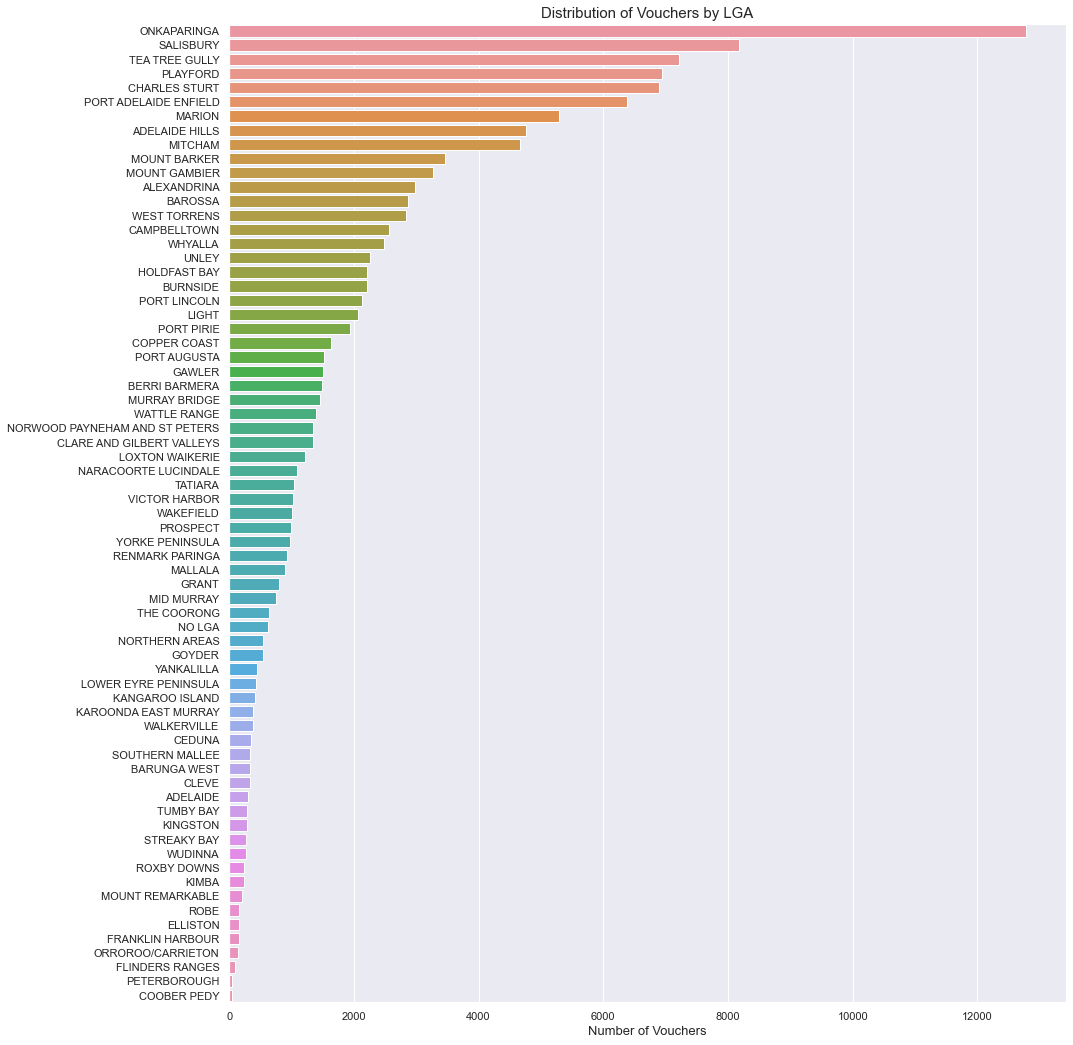

In [37]:
# show distribution of vouchers by LGA
sns.set_theme(style="darkgrid")
plt.figure(figsize=(15, 18))
LGA_vouchers = LGA_vouchers.sort_values("Voucher_Count", ascending = False)
sns.barplot(data=LGA_vouchers, x="Voucher_Count", y="Participant_LGA")
plt.title("Distribution of Vouchers by LGA", fontsize=15)
plt.xlabel("Number of Vouchers", fontsize = 13)
plt.ylabel("");

In [38]:
LGA_vouchers["Voucher_prop"] = round(LGA_vouchers["Voucher_Count"] / sum(LGA_vouchers["Voucher_Count"]) * 100, 2)
LGA_vouchers = LGA_vouchers.sort_values(by="Voucher_prop", ascending = False)
print("Proportion of number of vouchers for top 15 LGAs:\t", LGA_vouchers["Voucher_prop"].nlargest(15).sum())
print("Total number of LGAs:\t", LGA_vouchers.shape[0])

Proportion of number of vouchers for top 15 LGAs:	 63.599999999999994
Total number of LGAs:	 69


## Findings of LGA analysis:
It can clearly be seen that there is a highly uneven distribution between different areas. There are 69 LGAs in the dataset but only 15 of those account for around 64% of vouchers that have been redeemed throughout the state.

## By Sports

In [39]:
# group by sports
sports_vouchers = sa_vouchers_scores.groupby(
    "Voucher_Sport")["Voucher_Sport"].count().to_frame(name = 'Voucher_Count').reset_index()
sports_vouchers = sports_vouchers.sort_values(by='Voucher_Count', ascending= False)
sports_vouchers.head(10)

,Voucher_Sport,Voucher_Count
2,Australian Rules,47224
27,Netball,24017
15,Football (Soccer),15775
17,Gymnastics,9823
6,Basketball,6016
1,Athletics,4518
44,Tennis,3742
18,Hockey,3026
8,Calisthenics,2522
9,Cricket,1875


In [40]:
# calculate proportion of vouchers per sport, then show where 80% of vouchers are redeemed
sports_vouchers["Voucher_prop"] = round(sports_vouchers["Voucher_Count"]/sum(sports_vouchers["Voucher_Count"])*100, 2)
sports_vouchers.head(10)
    

,Voucher_Sport,Voucher_Count,Voucher_prop
2,Australian Rules,47224,37.03
27,Netball,24017,18.83
15,Football (Soccer),15775,12.37
17,Gymnastics,9823,7.70
6,Basketball,6016,4.72
1,Athletics,4518,3.54
44,Tennis,3742,2.93
18,Hockey,3026,2.37
8,Calisthenics,2522,1.98
9,Cricket,1875,1.47


In [41]:
sports_vouchers["Voucher_prop"].head(10).sum(), sports_vouchers.shape

(92.94000000000001, (50, 3))

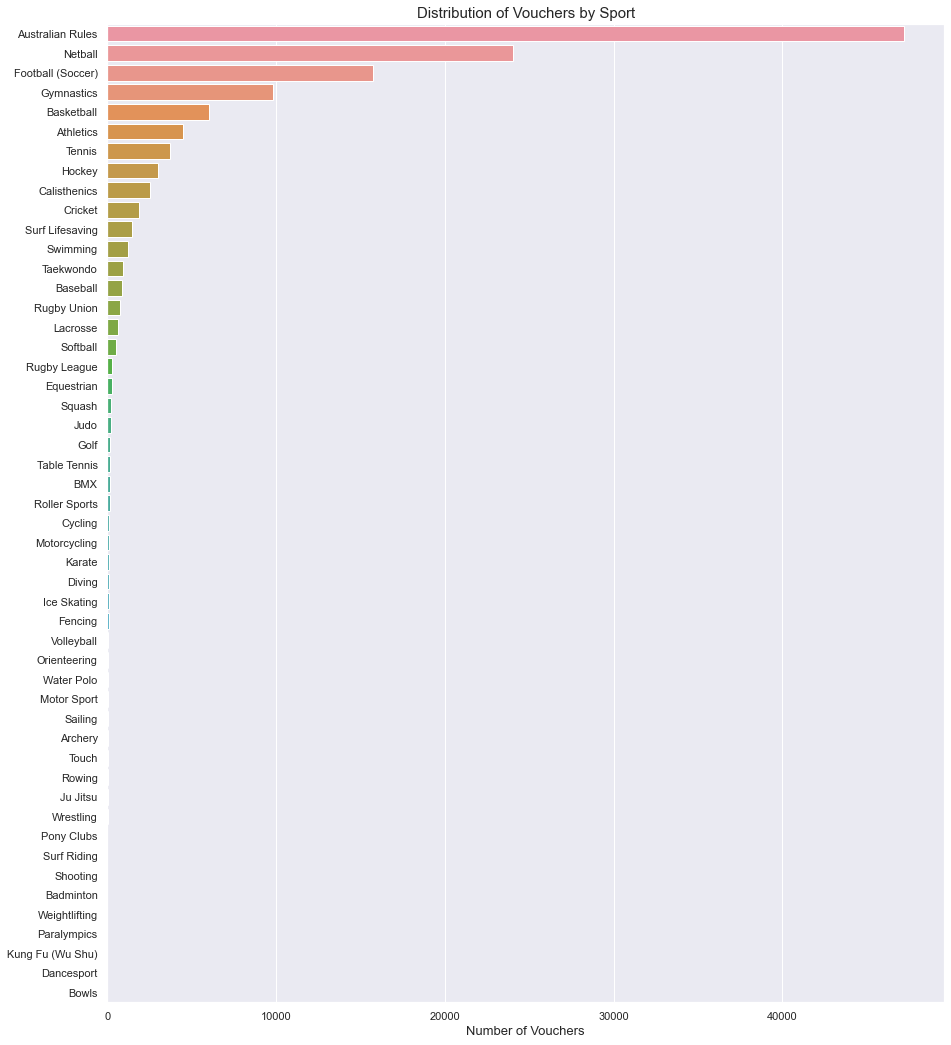

In [42]:
# show distribution of vouchers by sports
plt.figure(figsize=(15, 18))
sns.barplot(data=sports_vouchers, x="Voucher_Count", y="Voucher_Sport")
plt.title("Distribution of Vouchers by Sport", fontsize=15)
plt.xlabel("Number of Vouchers", fontsize = 13)
plt.ylabel("");

In [43]:
# show sports where less than 50 vouchers have been redeemed
sports_vouchers[sports_vouchers["Voucher_Count"] < 50]

,Voucher_Sport,Voucher_Count,Voucher_prop
47,Water Polo,48,0.04
25,Motor Sport,45,0.04
35,Sailing,40,0.03
0,Archery,34,0.03
45,Touch,23,0.02
32,Rowing,22,0.02
20,Ju Jitsu,22,0.02
49,Wrestling,19,0.01
30,Pony Clubs,17,0.01
40,Surf Riding,15,0.01


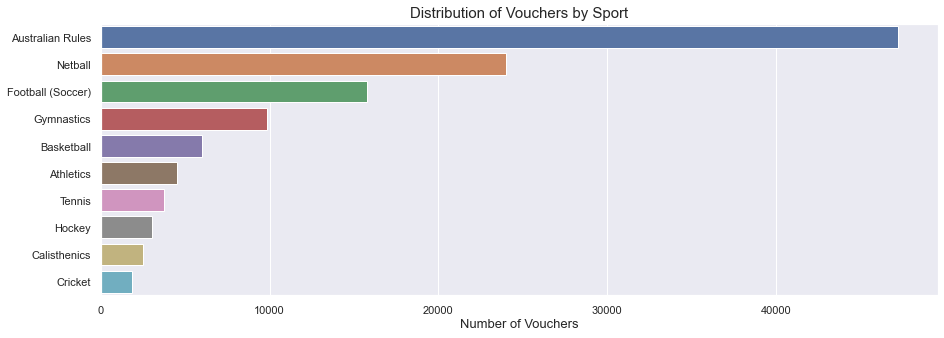

In [44]:
# show distribution of vouchers by more relevant sports
plt.figure(figsize=(15, 5))
sns.barplot(data=sports_vouchers.nlargest(10, "Voucher_Count"), x="Voucher_Count", y="Voucher_Sport")
plt.title("Distribution of Vouchers by Sport", fontsize=15)
plt.xlabel("Number of Vouchers", fontsize = 13)
plt.ylabel("");

## Findings of Sports analysis:

It can clearly be seen that the distribution of voucher redemption by sports is highly uneven. There are 50 sports to choose from, however, 10 of these account for over 90% of vouchers.

# Are some sports more popular in different parts of the state?

In [45]:
# select 10 most popular sports and 15 most populated states
LGA_top15 = LGA_vouchers.nlargest(15, "Voucher_Count")
sports_top10 = sports_vouchers.nlargest(10, "Voucher_Count")
sports_top10

,Voucher_Sport,Voucher_Count,Voucher_prop
2,Australian Rules,47224,37.03
27,Netball,24017,18.83
15,Football (Soccer),15775,12.37
17,Gymnastics,9823,7.70
6,Basketball,6016,4.72
1,Athletics,4518,3.54
44,Tennis,3742,2.93
18,Hockey,3026,2.37
8,Calisthenics,2522,1.98
9,Cricket,1875,1.47


In [46]:
# create list with popular sport
sports_list = sports_top10["Voucher_Sport"].tolist()
sports_list

['Australian Rules',
 'Netball',
 'Football (Soccer)',
 'Gymnastics',
 'Basketball',
 'Athletics',
 'Tennis',
 'Hockey',
 'Calisthenics',
 'Cricket']

In [47]:
# group by participants LGA and sports
LGA_sports_vouchers = sa_vouchers_scores.groupby(
    ["Participant_LGA", "Voucher_Sport"])["Participant_LGA"].count().to_frame(name = 'Voucher_Count').reset_index()
LGA_sports_vouchers

,Participant_LGA,Voucher_Sport,Voucher_Count
0,ADELAIDE,Athletics,16
1,ADELAIDE,Australian Rules,130
2,ADELAIDE,Baseball,1
3,ADELAIDE,Basketball,4
4,ADELAIDE,Calisthenics,1
...,...,...,...
1152,YORKE PENINSULA,Motorcycling,2
1153,YORKE PENINSULA,Netball,313
1154,YORKE PENINSULA,Surf Lifesaving,4
1155,YORKE PENINSULA,Taekwondo,87


In [48]:
# drop records that are not in list with most popular sport
LGA_sports_clean = LGA_sports_vouchers[LGA_sports_vouchers["Voucher_Sport"].isin(sports_list)]
LGA_sports_clean

,Participant_LGA,Voucher_Sport,Voucher_Count
0,ADELAIDE,Athletics,16
1,ADELAIDE,Australian Rules,130
3,ADELAIDE,Basketball,4
4,ADELAIDE,Calisthenics,1
5,ADELAIDE,Cricket,2
...,...,...,...
1147,YORKE PENINSULA,Football (Soccer),7
1149,YORKE PENINSULA,Gymnastics,1
1150,YORKE PENINSULA,Hockey,99
1153,YORKE PENINSULA,Netball,313


In [49]:
# reshape grouped output
LGA_sports_piv = pd.pivot_table(LGA_sports_clean, index="Participant_LGA", columns="Voucher_Sport", values="Voucher_Count")
LGA_sports_piv

Voucher_Sport,Athletics,Australian Rules,Basketball,Calisthenics,Cricket,Football (Soccer),Gymnastics,Hockey,Netball,Tennis
Participant_LGA,,,,,,,,,,
ADELAIDE,16.0,130.0,4.0,1.0,2.0,27.0,20.0,17.0,23.0,4.0
ADELAIDE HILLS,204.0,1412.0,48.0,62.0,128.0,812.0,176.0,52.0,1395.0,257.0
ALEXANDRINA,62.0,980.0,204.0,5.0,8.0,510.0,86.0,39.0,860.0,109.0
BAROSSA,158.0,1196.0,341.0,9.0,56.0,197.0,117.0,213.0,445.0,83.0
BARUNGA WEST,1.0,86.0,12.0,NaN,1.0,11.0,4.0,2.0,193.0,3.0
...,...,...,...,...,...,...,...,...,...,...
WEST TORRENS,114.0,907.0,70.0,45.0,85.0,425.0,386.0,49.0,268.0,158.0
WHYALLA,15.0,569.0,605.0,15.0,12.0,268.0,154.0,321.0,509.0,NaN
WUDINNA,29.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,194.0,NaN


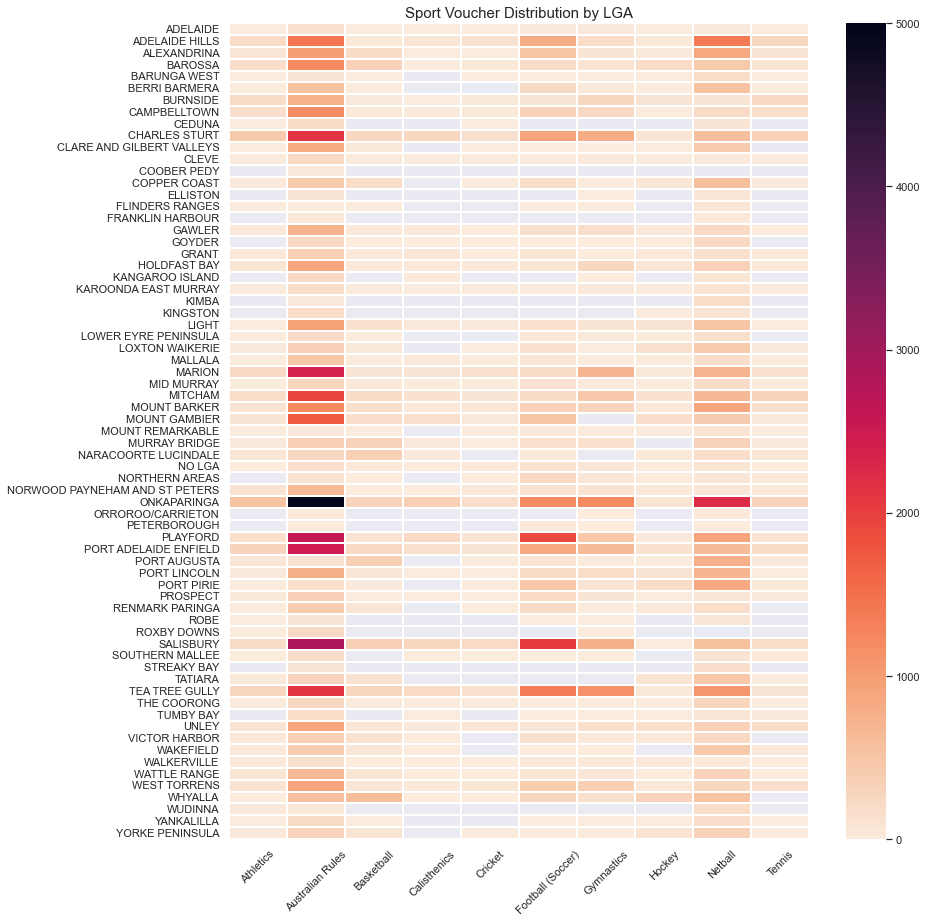

In [50]:
plt.figure(figsize=(13, 15))
sns.heatmap(LGA_sports_piv, vmin=0, vmax=5000, cmap=sns.cm.rocket_r, linewidths=0.1)
plt.title("Sport Voucher Distribution by LGA", fontsize = 15)
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=45);

There a few things to note about this heatmap:
1. Since all LGAs are included, there are a lot of empty values. Thus, it can be seen in which areas more or less vouchers are redeemed. In the following, another heatmap will be shown to get a more granular view between states that have higher voucher redemption. Actually, as it has been shown, this is due to population size and the hypothesis whether there is a difference between rural and metropolitan areas will be tested later with plotting a map.
2. The popluarity of sports is visualised on the map. The more popular a sport is, the less missing values it has across LGAs. It can be seen that vouchers for Australian Rules are redeemed in every single area, while Netball vouchers are redeemed in almost every area. This underlines their popularity throughout the state.

In [51]:
# create list with 15 most populated areas
LGA_list = LGA_top15["Participant_LGA"].tolist()
LGA_list

['ONKAPARINGA',
 'SALISBURY',
 'TEA TREE GULLY',
 'PLAYFORD',
 'CHARLES STURT',
 'PORT ADELAIDE ENFIELD',
 'MARION',
 'ADELAIDE HILLS',
 'MITCHAM',
 'MOUNT BARKER',
 'MOUNT GAMBIER',
 'ALEXANDRINA',
 'BAROSSA',
 'WEST TORRENS',
 'CAMPBELLTOWN']

In [52]:
# drop records from grouped df that are not in list with most populated areas
LGA_sports_clean2 = LGA_sports_clean[LGA_sports_clean["Participant_LGA"].isin(LGA_list)]
LGA_sports_clean2

,Participant_LGA,Voucher_Sport,Voucher_Count
22,ADELAIDE HILLS,Athletics,204
23,ADELAIDE HILLS,Australian Rules,1412
26,ADELAIDE HILLS,Basketball,48
27,ADELAIDE HILLS,Calisthenics,62
28,ADELAIDE HILLS,Cricket,128
...,...,...,...
1092,WEST TORRENS,Football (Soccer),425
1094,WEST TORRENS,Gymnastics,386
1095,WEST TORRENS,Hockey,49
1098,WEST TORRENS,Netball,268


In [53]:
# reshape grouped output
LGA_sports_piv2 = pd.pivot_table(LGA_sports_clean2, 
                                 index="Voucher_Sport", 
                                 columns="Participant_LGA", 
                                 values="Voucher_Count")
LGA_sports_piv2

Participant_LGA,ADELAIDE HILLS,ALEXANDRINA,BAROSSA,CAMPBELLTOWN,CHARLES STURT,MARION,MITCHAM,MOUNT BARKER,MOUNT GAMBIER,ONKAPARINGA,PLAYFORD,PORT ADELAIDE ENFIELD,SALISBURY,TEA TREE GULLY,WEST TORRENS
Voucher_Sport,,,,,,,,,,,,,,,
Athletics,204.0,62.0,158.0,162.0,447.0,238.0,176.0,107.0,86.0,541.0,147.0,298.0,214.0,280.0,114.0
Australian Rules,1412.0,980.0,1196.0,1186.0,2147.0,2362.0,1939.0,1230.0,1710.0,5258.0,2580.0,2453.0,2856.0,2131.0,907.0
Basketball,48.0,204.0,341.0,40.0,256.0,101.0,210.0,147.0,168.0,296.0,111.0,243.0,362.0,284.0,70.0
Calisthenics,62.0,5.0,9.0,26.0,266.0,104.0,125.0,47.0,155.0,353.0,216.0,150.0,282.0,231.0,45.0
Cricket,128.0,8.0,56.0,47.0,137.0,155.0,89.0,65.0,22.0,168.0,91.0,90.0,220.0,118.0,85.0
Football (Soccer),812.0,510.0,197.0,319.0,917.0,203.0,198.0,333.0,502.0,1204.0,1880.0,853.0,2069.0,1356.0,425.0
Gymnastics,176.0,86.0,117.0,248.0,807.0,719.0,457.0,294.0,NaN,1211.0,451.0,627.0,763.0,1114.0,386.0
Hockey,52.0,39.0,213.0,17.0,87.0,57.0,123.0,36.0,164.0,82.0,34.0,124.0,17.0,42.0,49.0
Netball,1395.0,860.0,445.0,205.0,584.0,723.0,658.0,880.0,393.0,2242.0,904.0,630.0,566.0,1068.0,268.0


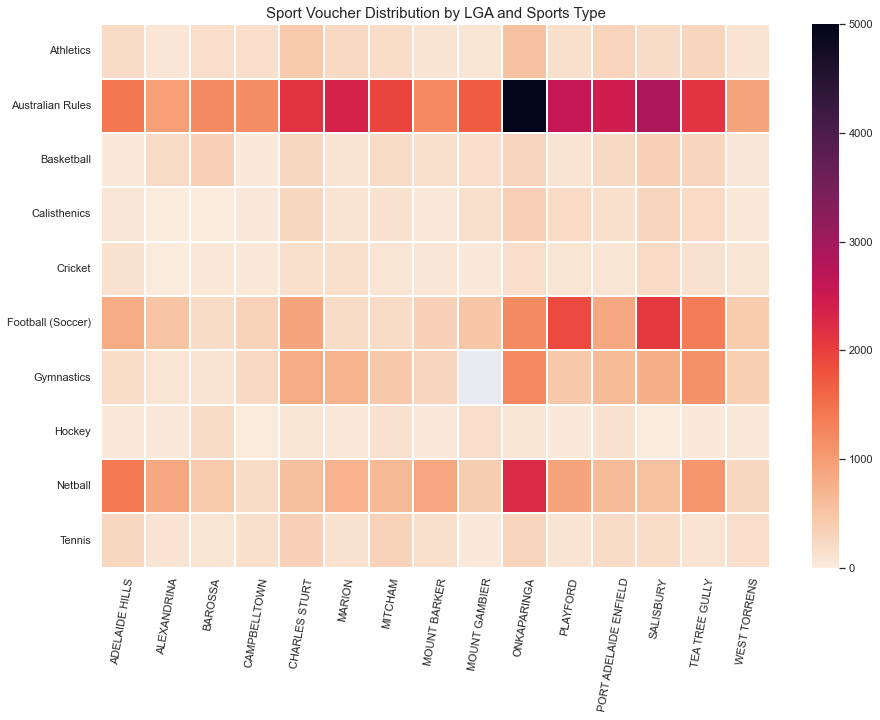

In [54]:
# create heatmap with most populated areas
plt.figure(figsize=(15, 10))
sns.heatmap(LGA_sports_piv2, vmin=0, vmax=5000, cmap=sns.cm.rocket_r, linewidth=0.1)
plt.title("Sport Voucher Distribution by LGA and Sports Type", fontsize = 15)
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=80);

## Findings:
It can clearly be seen that Australian Rules is by far the most popular sport across all states. Even in the top 15 LGAs, this sport still stands out. It is also clear that it is especially popular in Onkaparinga.

## Plot Voucher distribution on Map

In [55]:
map_df.head()

,lgatype,abbname,lga,shape_Length,shape_Area,geometry,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,...,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000830.0,ADELAIDE,Not Registered Previously,Not ATSI,...,Football (Soccer),ADELAIDE,ADELAIDE,29/5/15 0:01,2015.0,874.0,874.0,1036.0,1013.0,19606.0
1,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000831.0,ADELAIDE,Registered Previously,Not ATSI,...,Athletics,ADELAIDE,ADELAIDE,29/12/15 3:31,2015.0,874.0,874.0,1036.0,1013.0,19606.0
2,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000833.0,ADELAIDE,Registered Previously,Not ATSI,...,Australian Rules,ADELAIDE,ADELAIDE,7/6/16 3:12,2016.0,874.0,874.0,1036.0,1013.0,19606.0
3,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000833.0,ADELAIDE,Registered Previously,Not ATSI,...,Australian Rules,ADELAIDE,ADELAIDE,9/11/15 2:24,2015.0,874.0,874.0,1036.0,1013.0,19606.0
4,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000834.0,ADELAIDE,Not Registered Previously,Not ATSI,...,Athletics,ADELAIDE,ADELAIDE,29/11/16 6:50,2016.0,874.0,874.0,1036.0,1013.0,19606.0


In [56]:
# join relevant columns with count aggregate
voucher_count = sa_vouchers_scores.groupby(
    "Participant_LGA")["Participant_LGA"].count().to_frame(name = 'Voucher_Count').reset_index()
plot_count = map_df[['abbname', 'geometry']]
plot = pd.merge(plot_count, voucher_count, how='left', left_on = 'abbname', right_on = 'Participant_LGA')
plot = plot.drop("Participant_LGA", axis=1)
plot

,abbname,geometry,Voucher_Count
0,ADELAIDE,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",302.0
1,ADELAIDE,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",302.0
2,ADELAIDE,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",302.0
3,ADELAIDE,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",302.0
4,ADELAIDE,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",302.0
...,...,...,...
126903,NaN,None,NaN
126904,NaN,None,NaN
126905,NaN,None,NaN
126906,NaN,None,NaN


In [57]:
# keep distinct records and drop LGA without vouchers
plot_distinct = plot.drop_duplicates()
plot_distinct = plot_distinct.dropna()
plot_distinct

,abbname,geometry,Voucher_Count
0,ADELAIDE,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",302.0
302,BURNSIDE,"MULTIPOLYGON (((138.69662 -34.92009, 138.69746...",2213.0
2515,MOUNT GAMBIER,"MULTIPOLYGON (((140.78651 -37.80198, 140.78662...",3271.0
5786,PORT ADELAIDE ENFIELD,"MULTIPOLYGON (((138.51045 -34.79261, 138.50967...",6384.0
12170,PORT AUGUSTA,"MULTIPOLYGON (((137.75403 -32.37753, 137.75448...",1522.0
...,...,...,...
113237,ROXBY DOWNS,"MULTIPOLYGON (((136.89787 -30.48077, 136.89787...",234.0
113471,TEA TREE GULLY,"MULTIPOLYGON (((138.77559 -34.73521, 138.77396...",7219.0
120690,WEST TORRENS,"MULTIPOLYGON (((138.57680 -34.90910, 138.57685...",2844.0
123534,MURRAY BRIDGE,"MULTIPOLYGON (((139.01938 -34.95261, 139.02040...",1462.0


In [58]:
plot_distinct[(plot_distinct['abbname']=='ROXBY DOWNS') | (plot_distinct['abbname']=='COOBER PEDY')]

,abbname,geometry,Voucher_Count
54332,COOBER PEDY,"MULTIPOLYGON (((134.80915 -29.05169, 134.80757...",39.0
113237,ROXBY DOWNS,"MULTIPOLYGON (((136.89787 -30.48077, 136.89787...",234.0


In [59]:
plot_distinct1 = plot_distinct.drop((
    plot_distinct[plot_distinct['abbname']=='ROXBY DOWNS'].index) | 
    (plot_distinct[plot_distinct['abbname']=='COOBER PEDY'].index))
plot_distinct1

/var/folders/31/2xxsfpps75923jkzs3xks1w00000gq/T/ipykernel_17916/4236694386.py:1: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  plot_distinct1 = plot_distinct.drop((


,abbname,geometry,Voucher_Count
0,ADELAIDE,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",302.0
302,BURNSIDE,"MULTIPOLYGON (((138.69662 -34.92009, 138.69746...",2213.0
2515,MOUNT GAMBIER,"MULTIPOLYGON (((140.78651 -37.80198, 140.78662...",3271.0
5786,PORT ADELAIDE ENFIELD,"MULTIPOLYGON (((138.51045 -34.79261, 138.50967...",6384.0
12170,PORT AUGUSTA,"MULTIPOLYGON (((137.75403 -32.37753, 137.75448...",1522.0
...,...,...,...
111302,PORT PIRIE,"MULTIPOLYGON (((138.16422 -33.10628, 138.16488...",1935.0
113471,TEA TREE GULLY,"MULTIPOLYGON (((138.77559 -34.73521, 138.77396...",7219.0
120690,WEST TORRENS,"MULTIPOLYGON (((138.57680 -34.90910, 138.57685...",2844.0
123534,MURRAY BRIDGE,"MULTIPOLYGON (((139.01938 -34.95261, 139.02040...",1462.0


Note: the three LGAs with 0 vouchers have been removed since they distort the visualisation of the map. These are all in the north of the state and do not add information, but rather occupy half of the map which leads to relevant states being too small and not distinguishable. Roxby Downs and Coober Pedy are removed too because they are in between the other three that do not add information. Even though there are vouchers redeemed, the number is insignificantly small.

In [60]:
top5 = plot_distinct1.sort_values("Voucher_Count", ascending=False).nlargest(5, "Voucher_Count")
top5

,abbname,geometry,Voucher_Count
91580,ONKAPARINGA,"MULTIPOLYGON (((138.56395 -35.02975, 138.56397...",12782.0
24033,SALISBURY,"MULTIPOLYGON (((138.65927 -34.72560, 138.65598...",8169.0
113471,TEA TREE GULLY,"MULTIPOLYGON (((138.77559 -34.73521, 138.77396...",7219.0
104362,PLAYFORD,"MULTIPOLYGON (((138.67086 -34.61590, 138.67110...",6940.0
74426,CHARLES STURT,"MULTIPOLYGON (((138.47942 -34.85039, 138.48376...",6897.0


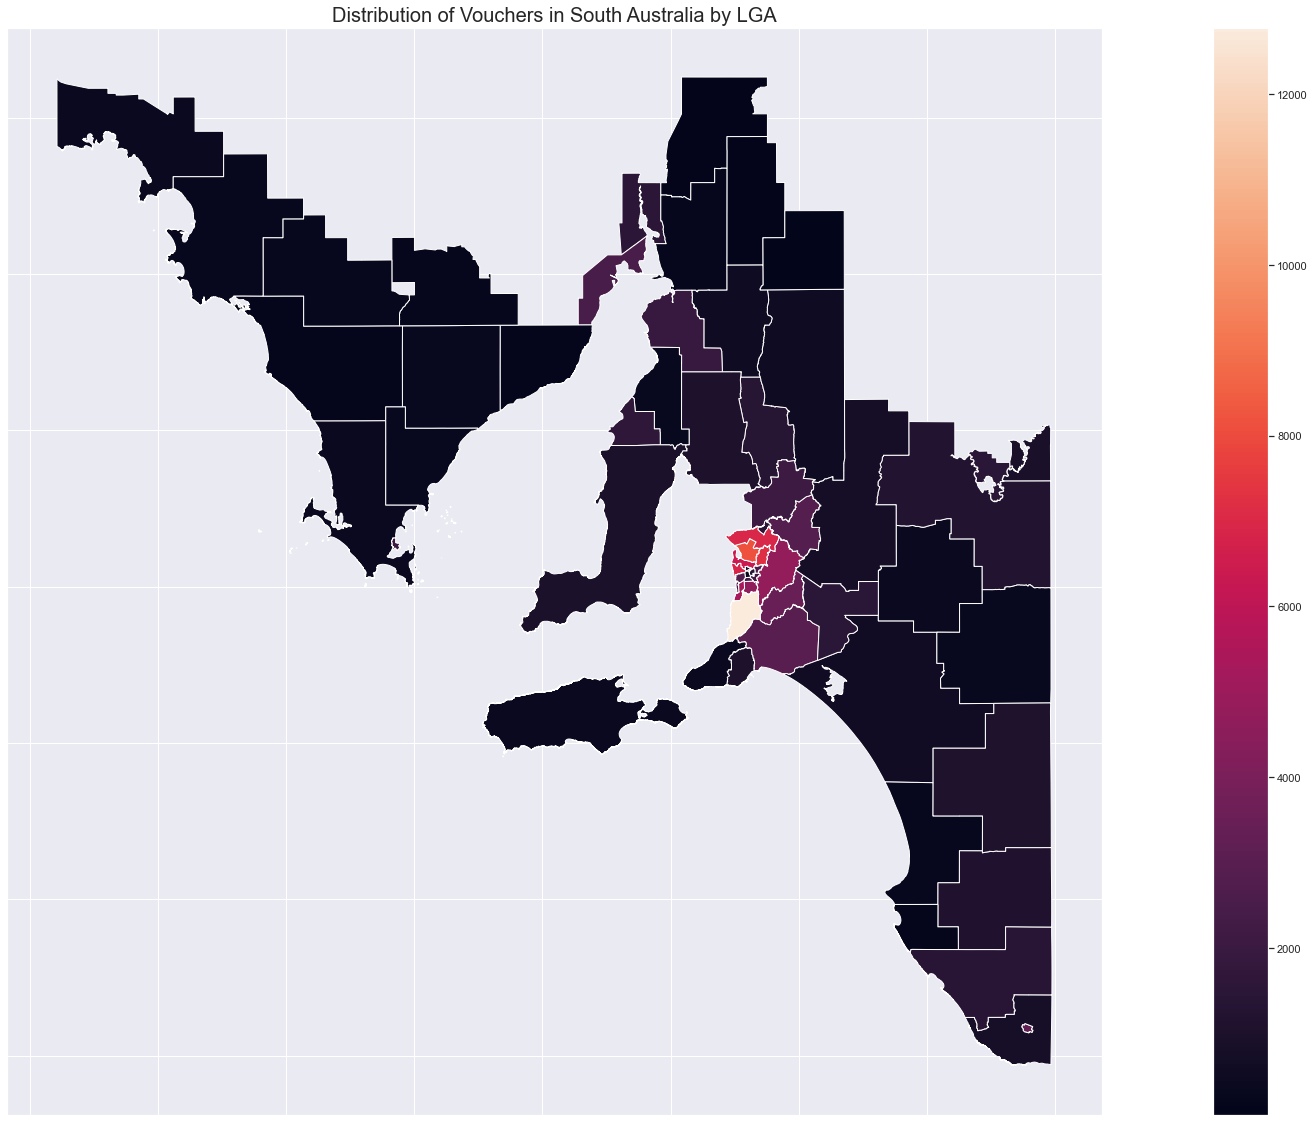

In [61]:
# plot voucher count on map
plt.rcParams["figure.figsize"] = (40, 20)
plot_distinct1.plot(column='Voucher_Count', legend=True)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, labelleft=False)
plt.title("Distribution of Vouchers in South Australia by LGA", fontsize=20);

As expected, the LGAs with most number of vouchers are found in the metropolitan area around Adelaide.

# Are any LGAs over/under represented in their use of vouchers?

In [62]:
# extract LGAs and respective population from main dataframe
population = sa_vouchers_scores.drop_duplicates("Participant_LGA")[["Participant_LGA", "Population"]]
population.sort_values(by='Participant_LGA')

,Participant_LGA,Population
829,ADELAIDE,19606
1275,ADELAIDE HILLS,38601
4122,ALEXANDRINA,23693
3093,BAROSSA,22174
2839,BARUNGA WEST,2467
...,...,...
5287,WEST TORRENS,54932
71759,WHYALLA,22070
51891,WUDINNA,1256
6436,YANKALILLA,4406


In [63]:
# check for missing values 
population[population["Population"].isnull()]

,Participant_LGA,Population


Missing values will be read in from the 2016 census data manually. In the original government data, there is a record for 'unincorporated' LGA which is explained as communities that do not belong to any LGA. Thus, it is assumed that 'NO LGA' reflects this category since 'unincorporated' cannot be found in the dataframe.

In [64]:
dict_update = {'NO LGA': 3583, 
               'LIGHT': 15041, 
               'ADELAIDE PLAINS': 8912, 
               'BERRI BARMERA': 10838, 
               'NARACOORTE LUCINDALE': 8544, 
               'PORT PIRIE': 17767,
               'NORWOOD PAYNEHAM AND ST PETERS': 36396}

dict_update['NO LGA']

3583

In [65]:
# for loop to fill missing values in

NANs = population[population["Population"].isnull()]['Participant_LGA']

for i, value in enumerate(NANs):
    myList = list(NANs.index) # create a list of indexes of the missing values
    print(myList)
    population['Population'][myList[i]] = dict_update[value] 
    
population[population["Population"].isnull()]

,Participant_LGA,Population


In [66]:
# Concatenate to single dataframe
LGA_vouchers = LGA_vouchers.sort_values(by='Participant_LGA')
pop_lga = pd.merge(population, LGA_vouchers, 'outer', 'Participant_LGA')
pop_lga

,Participant_LGA,Population,Voucher_Count,Voucher_prop
0,ONKAPARINGA,159517,12782,10.02
1,ADELAIDE,19606,302,0.24
2,YORKE PENINSULA,11046,977,0.77
3,CHARLES STURT,104922,6897,5.41
4,PORT ADELAIDE ENFIELD,112797,6384,5.01
...,...,...,...,...
64,MOUNT GAMBIER,25254,3271,2.56
65,WHYALLA,22070,2488,1.95
66,PETERBOROUGH,1733,45,0.04
67,PORT LINCOLN,14083,2125,1.67


In [67]:
# show correlation between population and number of vouchers
pop_lga.corr()

,Population,Voucher_Count,Voucher_prop
Population,1.000000,0.960068,0.960152
Voucher_Count,0.960068,1.000000,0.999999
Voucher_prop,0.960152,0.999999,1.000000


Since there is a high correlation, this indicates that the number of vouchers per area should be considered relatively to population size for comparison. <br >
__Note:__ This has been already inferred from the map since metropolitan areas had a higher number of vouchers than rural areas, indicating that this is due to the larger number of people living in that area.

In [68]:
# create column of number of vouchers per hundred people in each LGA
pop_lga["Voucher_Per_100"] = round(
    (pop_lga["Voucher_Count"] / pop_lga["Population"]) * 100, 2)
pop_lga = pop_lga.sort_values("Voucher_Per_100", ascending = False)
pop_lga

,Participant_LGA,Population,Voucher_Count,Voucher_prop,Voucher_Per_100
27,KAROONDA EAST MURRAY,1035,388,0.30,37.49
46,KIMBA,1087,232,0.18,21.34
63,WUDINNA,1256,267,0.21,21.26
18,CLEVE,1729,329,0.26,19.03
60,SOUTHERN MALLEE,2097,342,0.27,16.31
...,...,...,...,...,...
55,PROSPECT,19950,986,0.77,4.94
54,NORWOOD PAYNEHAM AND ST PETERS,34863,1352,1.06,3.88
66,PETERBOROUGH,1733,45,0.04,2.60
56,COOBER PEDY,1694,39,0.03,2.30


In [69]:
# check mean of column
mean = pop_lga['Voucher_Per_100'].mean()
mean

10.741739130434777

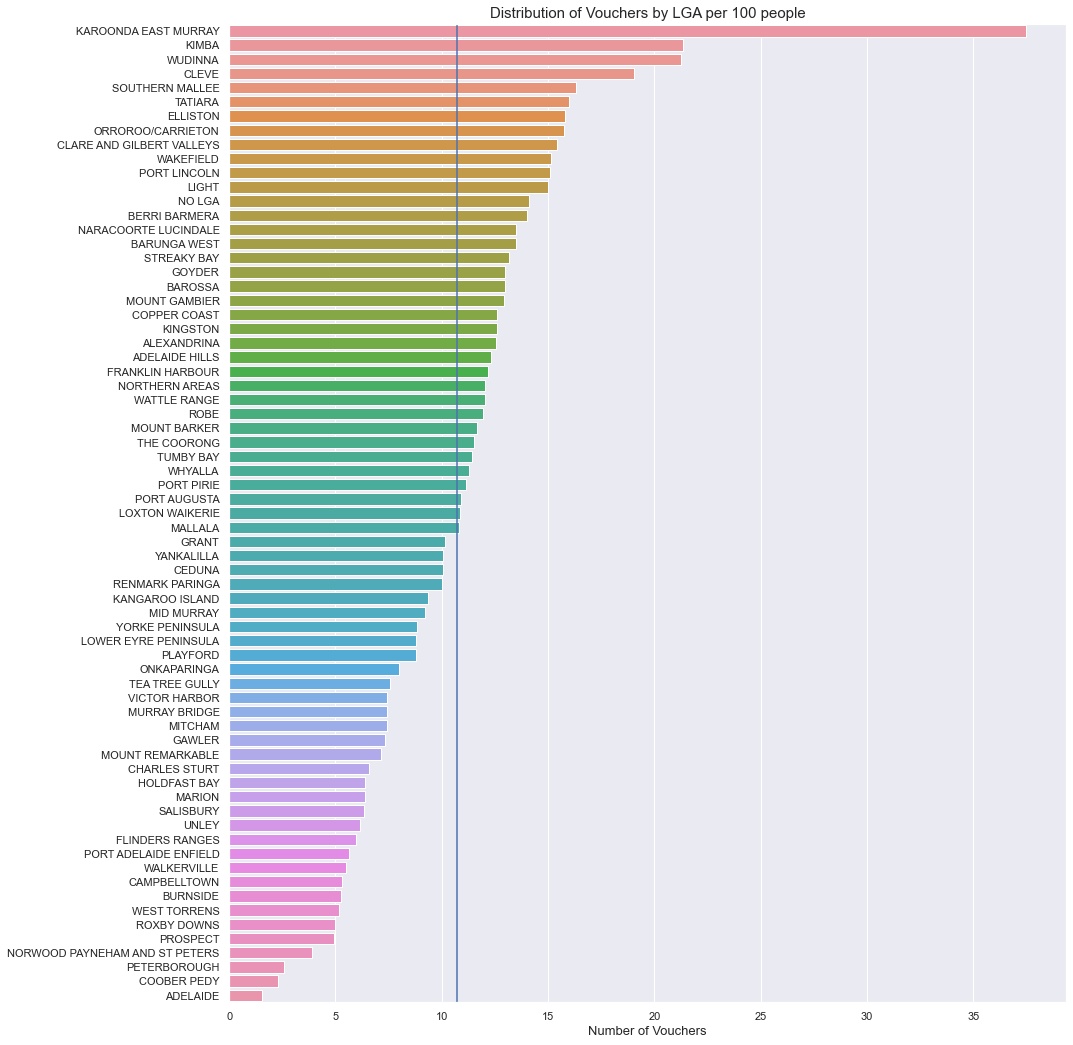

In [70]:
# plot a barplot with mean line to show deviation of LGAs
plt.figure(figsize=(15, 18))
sns.barplot(data=pop_lga, x="Voucher_Per_100", y="Participant_LGA")
plt.title("Distribution of Vouchers by LGA per 100 people", fontsize=15)
plt.xlabel("Number of Vouchers", fontsize = 13)
plt.ylabel("")
plt.axvline(mean);

In [71]:
# show all overrepresented LGAs
pop_lga[pop_lga['Voucher_Per_100'] > mean]

,Participant_LGA,Population,Voucher_Count,Voucher_prop,Voucher_Per_100
27,KAROONDA EAST MURRAY,1035,388,0.30,37.49
46,KIMBA,1087,232,0.18,21.34
63,WUDINNA,1256,267,0.21,21.26
18,CLEVE,1729,329,0.26,19.03
60,SOUTHERN MALLEE,2097,342,0.27,16.31
29,TATIARA,6559,1048,0.82,15.98
58,ELLISTON,1045,165,0.13,15.79
50,ORROROO/CARRIETON,871,137,0.11,15.73
10,CLARE AND GILBERT VALLEYS,8750,1349,1.06,15.42
25,WAKEFIELD,6663,1010,0.79,15.16


In [72]:
# show all underrepresented LGAs
pop_lga[pop_lga['Voucher_Per_100'] < mean]

,Participant_LGA,Population,Voucher_Count,Voucher_prop,Voucher_Per_100
8,GRANT,7840,795,0.62,10.14
28,YANKALILLA,4406,443,0.35,10.05
49,CEDUNA,3485,350,0.27,10.04
51,RENMARK PARINGA,9231,925,0.73,10.02
12,KANGAROO ISLAND,4415,413,0.32,9.35
16,MID MURRAY,8134,751,0.59,9.23
2,YORKE PENINSULA,11046,977,0.77,8.84
44,LOWER EYRE PENINSULA,4916,433,0.34,8.81
13,PLAYFORD,79082,6940,5.44,8.78
0,ONKAPARINGA,159517,12782,10.02,8.01


In [73]:
plot_distinct

,abbname,geometry,Voucher_Count
0,ADELAIDE,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",302.0
302,BURNSIDE,"MULTIPOLYGON (((138.69662 -34.92009, 138.69746...",2213.0
2515,MOUNT GAMBIER,"MULTIPOLYGON (((140.78651 -37.80198, 140.78662...",3271.0
5786,PORT ADELAIDE ENFIELD,"MULTIPOLYGON (((138.51045 -34.79261, 138.50967...",6384.0
12170,PORT AUGUSTA,"MULTIPOLYGON (((137.75403 -32.37753, 137.75448...",1522.0
...,...,...,...
113237,ROXBY DOWNS,"MULTIPOLYGON (((136.89787 -30.48077, 136.89787...",234.0
113471,TEA TREE GULLY,"MULTIPOLYGON (((138.77559 -34.73521, 138.77396...",7219.0
120690,WEST TORRENS,"MULTIPOLYGON (((138.57680 -34.90910, 138.57685...",2844.0
123534,MURRAY BRIDGE,"MULTIPOLYGON (((139.01938 -34.95261, 139.02040...",1462.0


In [74]:
# merge with geodata 
plot_proportion = pd.merge(plot_distinct1, pop_lga, how='inner', left_on='abbname', right_on='Participant_LGA')
plot_proportion

,abbname,geometry,Voucher_Count_x,Participant_LGA,Population,Voucher_Count_y,Voucher_prop,Voucher_Per_100
0,ADELAIDE,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",302.0,ADELAIDE,19606,302,0.24,1.54
1,BURNSIDE,"MULTIPOLYGON (((138.69662 -34.92009, 138.69746...",2213.0,BURNSIDE,42168,2213,1.74,5.25
2,MOUNT GAMBIER,"MULTIPOLYGON (((140.78651 -37.80198, 140.78662...",3271.0,MOUNT GAMBIER,25254,3271,2.56,12.95
3,PORT ADELAIDE ENFIELD,"MULTIPOLYGON (((138.51045 -34.79261, 138.50967...",6384.0,PORT ADELAIDE ENFIELD,112797,6384,5.01,5.66
4,PORT AUGUSTA,"MULTIPOLYGON (((137.75403 -32.37753, 137.75448...",1522.0,PORT AUGUSTA,13978,1522,1.19,10.89
...,...,...,...,...,...,...,...,...
60,PORT PIRIE,"MULTIPOLYGON (((138.16422 -33.10628, 138.16488...",1935.0,PORT PIRIE,17360,1935,1.52,11.15
61,TEA TREE GULLY,"MULTIPOLYGON (((138.77559 -34.73521, 138.77396...",7219.0,TEA TREE GULLY,95461,7219,5.66,7.56
62,WEST TORRENS,"MULTIPOLYGON (((138.57680 -34.90910, 138.57685...",2844.0,WEST TORRENS,54932,2844,2.23,5.18
63,MURRAY BRIDGE,"MULTIPOLYGON (((139.01938 -34.95261, 139.02040...",1462.0,MURRAY BRIDGE,19742,1462,1.15,7.41


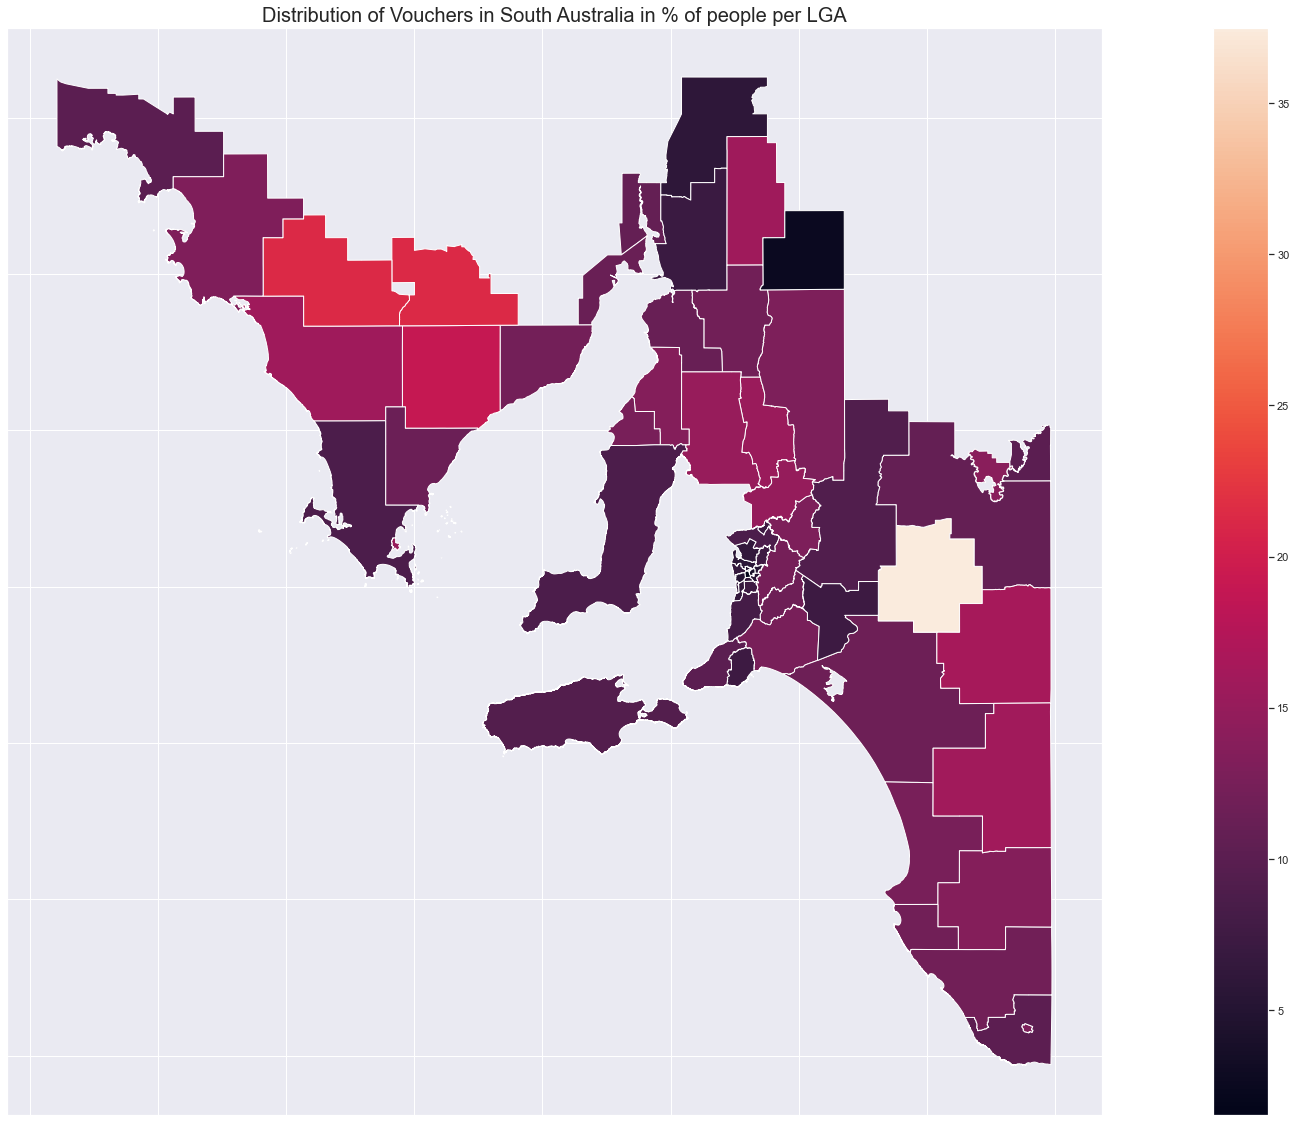

In [75]:
# plot map
plt.rcParams["figure.figsize"] = (40, 20)
plot_proportion.plot(column='Voucher_Per_100', legend=True)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, labelleft=False)
plt.title("Distribution of Vouchers in South Australia in % of people per LGA", fontsize=20);

## Findings of LGA analysis:

For this analysis, it can be seen that, first, the distribution of redeemed vouchers has changed by a lot and, second, the distribution is more even than without taking population size into consideration.<br >
For example, in Karoonda East Murray, only 388 vouchers were redeemed which puts them at the lower end of number of vouchers per LGA. However, after considering population size, it becomes clear that out of 100 people in this LGA, around 38 redeem sports vouchers which indicates an overrepresentation in this LGA since almost 4 times as many people redeem vouchers compared to the average value. On the contrary, there is the city of Adelaide where only 1.54 percent of people redeem vouchers which is almost only a tenth of the average voucher redemption when population is considered.
From the last map, it can also be seen that the overrepresentation of voucher usage seems to apply especially to rural areas while the metropolitan area around Adelaide seems to be underrepresentated. In the following it will be analysed, if there is a relationship between the voucher usage and socioeconomic factors.

# Is there a relationship between any of the SEIFA measures and voucher use in an LGA?

1. Conduct univariate analysis of variables
    1. catogorise into low, mid, high socioeconomic area
    2. transform categorical variables into binary format
2. Conduct bivariate analysis of variables with target variable
3. Build a linear regression model
4. Build a logistic regression model



In [76]:
LGA_scores

INDEX_TYPE,IEO,IER,IRSAD,IRSD,Population
LGA,,,,,
ADELAIDE,874,874,1036,1013,19606
ADELAIDE HILLS,1083,1083,1077,1081,38601
ALEXANDRINA,1000,1000,969,987,23693
ANANGU PITJANTJATJARA,623,623,672,593,2433
BAROSSA,1028,1028,997,1017,22174
...,...,...,...,...,...
WEST TORRENS,949,949,989,998,54932
WHYALLA,905,905,897,905,22070
WUDINNA,1008,1008,999,1023,1256


In [77]:
pop_lga = pop_lga.set_index('Participant_LGA').sort_index()
pop_lga

,Population,Voucher_Count,Voucher_prop,Voucher_Per_100
Participant_LGA,,,,
ADELAIDE,19606,302,0.24,1.54
ADELAIDE HILLS,38601,4756,3.73,12.32
ALEXANDRINA,23693,2979,2.34,12.57
BAROSSA,22174,2874,2.25,12.96
BARUNGA WEST,2467,333,0.26,13.50
...,...,...,...,...
WEST TORRENS,54932,2844,2.23,5.18
WHYALLA,22070,2488,1.95,11.27
WUDINNA,1256,267,0.21,21.26


__Note:__ There are two records less in the pop_lga DataFrame than in the LGA_scores DataFrame. This is because these two records got lost when joining the SEIFA data on the Voucher data as there are no Voucher data for them. Since there is no voucher data on them, these will not be considered.

In [79]:
# join on lga
LGA_scores = pd.merge(LGA_scores, pop_lga['Voucher_Per_100'], how='inner', left_index=True, right_index=True)
LGA_scores

,IEO,IER,IRSAD,IRSD,Population,Voucher_Per_100
ADELAIDE,874,874,1036,1013,19606,1.54
ADELAIDE HILLS,1083,1083,1077,1081,38601,12.32
ALEXANDRINA,1000,1000,969,987,23693,12.57
BAROSSA,1028,1028,997,1017,22174,12.96
BARUNGA WEST,981,981,940,954,2467,13.50
...,...,...,...,...,...,...
WEST TORRENS,949,949,989,998,54932,5.18
WHYALLA,905,905,897,905,22070,11.27
WUDINNA,1008,1008,999,1023,1256,21.26
YANKALILLA,990,990,957,972,4406,10.05


In [81]:
sa_vouchers_scores

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996,996,975,993,159517
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996,996,975,993,159517
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996,996,975,993,159517
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996,996,975,993,159517
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996,996,975,993,159517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127521,1127524,ZADOWS LANDING,Registered Previously,Not ATSI,Not CALD,Female,50,Mannum Roos Netball Club,Netball,MID MURRAY,SCHUBERT,15/8/16 1:33,2016,965,965,917,937,8134
127522,1127524,ZADOWS LANDING,Registered Previously,Not ATSI,Not CALD,Female,50,Mannum Roos Netball Club,Netball,MID MURRAY,SCHUBERT,13/7/15 23:42,2015,965,965,917,937,8134
127523,1127524,ZADOWS LANDING,Registered Previously,Not ATSI,Not CALD,Female,50,Mannum Roos Netball Club,Netball,MID MURRAY,SCHUBERT,30/6/17 6:07,2017,965,965,917,937,8134
127524,1127526,ZADOWS LANDING,Registered Previously,Not ATSI,Not CALD,Female,50,Mannum Roos Netball Club,Netball,MID MURRAY,SCHUBERT,28/4/15 0:06,2015,965,965,917,937,8134


## Conduct univariate analysis of variables

### ATSI

In [98]:
atsi = sa_vouchers_scores.groupby(
    by=['Participant_ATSI_Indicator'])[['Participant_ATSI_Indicator']].count()
atsi

,Participant_ATSI_Indicator
Participant_ATSI_Indicator,
ATSI,4026
Not ATSI,123500


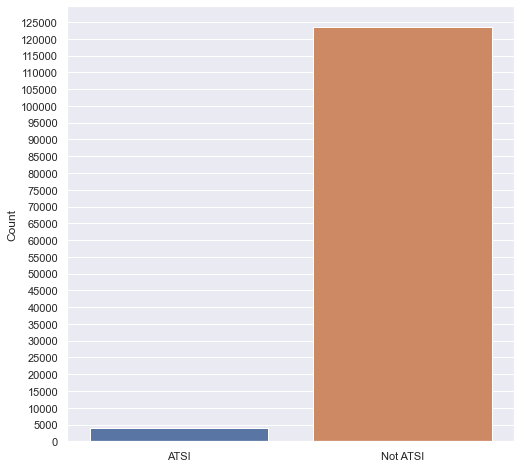

In [107]:
plt.figure(figsize=(8,8))
sns.barplot(x=atsi.index, y=atsi['Participant_ATSI_Indicator'])
plt.xlabel("")
plt.ylabel("Count")
plt.yticks(np.arange(0, 130000, 5000));

In [110]:
atsi['%'] = round(atsi['Participant_ATSI_Indicator'] / sum(atsi['Participant_ATSI_Indicator']) *100, 2)
atsi

,Participant_ATSI_Indicator,%
Participant_ATSI_Indicator,,
ATSI,4026,3.16
Not ATSI,123500,96.84


It can clearly be seen that there is only a small minority of people in the dataset that identify with an aboriginal or Torres Strait Island heritage. For later analysis, the variable is transformed to binary output.

In [119]:
sa_master = sa_vouchers_scores.copy(deep=True)
sa_master['Not_Aboriginal'] = np.where(
    sa_vouchers_scores['Participant_ATSI_Indicator'].str.contains('Not'), 1, 0)
sa_master = sa_master.drop('Participant_ATSI_Indicator', axis=1)
sa_master.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population,Not_ATSI,Not_Aboriginal
0,1000002,ABERFOYLE PARK,Registered Previously,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996,996,975,993,159517,1,1
1,1000002,ABERFOYLE PARK,Registered Previously,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996,996,975,993,159517,1,1
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996,996,975,993,159517,1,1
3,1000004,ABERFOYLE PARK,Registered Previously,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996,996,975,993,159517,1,1
4,1000005,ABERFOYLE PARK,Registered Previously,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996,996,975,993,159517,1,1


### CALD

In [115]:
cald = sa_vouchers_scores.groupby(
    by=['Participant_CALD_Indicator'])[['Participant_CALD_Indicator']].count()
cald

,Participant_CALD_Indicator
Participant_CALD_Indicator,
CALD,8532
Not CALD,118994


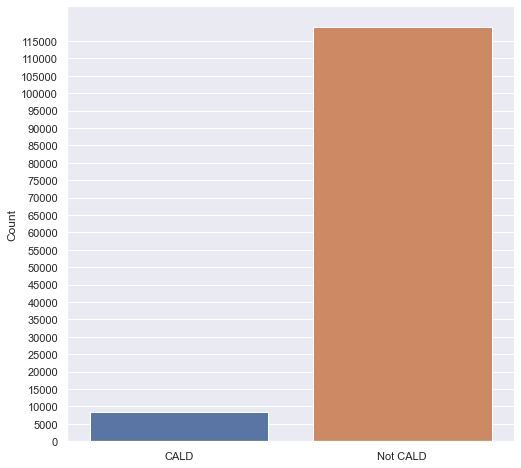

In [117]:
plt.figure(figsize=(8,8))
sns.barplot(x=cald.index, y=cald['Participant_CALD_Indicator'])
plt.xlabel("")
plt.ylabel("Count")
plt.yticks(np.arange(0, 120000, 5000));

In [118]:
cald['%'] = round(cald['Participant_CALD_Indicator'] / sum(cald['Participant_CALD_Indicator']) *100, 2)
cald

,Participant_CALD_Indicator,%
Participant_CALD_Indicator,,
CALD,8532,6.69
Not CALD,118994,93.31


It can clearly be seen that there is only a small minority of people in the dataset that have a non-Australian cultural background (CALD) background. For later analysis, the variable is transformed to binary output.

In [120]:
sa_master['Australian'] = np.where(
    sa_vouchers_scores['Participant_CALD_Indicator'].str.contains('Not'), 1, 0)
sa_master = sa_master.drop('Participant_CALD_Indicator', axis=1)
sa_master.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population,Not_ATSI,Not_Aboriginal,Australian
0,1000002,ABERFOYLE PARK,Registered Previously,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996,996,975,993,159517,1,1,1
1,1000002,ABERFOYLE PARK,Registered Previously,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996,996,975,993,159517,1,1,1
2,1000004,ABERFOYLE PARK,Not Registered Previously,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996,996,975,993,159517,1,1,1
3,1000004,ABERFOYLE PARK,Registered Previously,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996,996,975,993,159517,1,1,1
4,1000005,ABERFOYLE PARK,Registered Previously,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996,996,975,993,159517,1,1,1


### Sex

In [121]:
sex = sa_vouchers_scores.groupby(
    by=['Participant_Sex'])[['Participant_Sex']].count()
sex

,Participant_Sex
Participant_Sex,
Female,54327
Male,73199


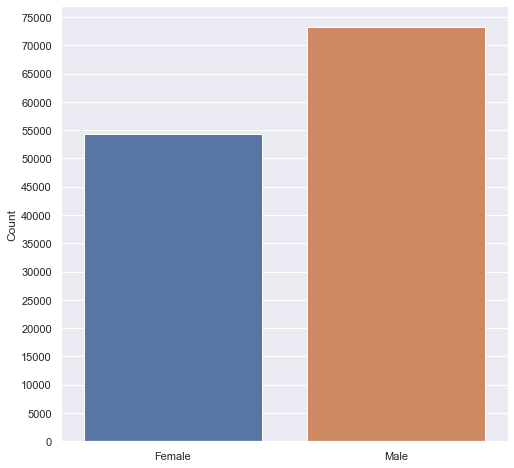

In [122]:
plt.figure(figsize=(8,8))
sns.barplot(x=sex.index, y=sex['Participant_Sex'])
plt.xlabel("")
plt.ylabel("Count")
plt.yticks(np.arange(0, 80000, 5000));

In [123]:
sex['%'] = round(sex['Participant_Sex'] / sum(sex['Participant_Sex']) *100, 2)
sex

,Participant_Sex,%
Participant_Sex,,
Female,54327,42.6
Male,73199,57.4


The above analysis reveals that there are more males than females in the data ven though the difference is not very large. For later analysis, the variable is transformed to binary output.

In [124]:
sa_master['Male'] = np.where(
    sa_vouchers_scores['Participant_Sex'].str.contains('Male'), 1, 0)
sa_master = sa_master.drop('Participant_Sex', axis=1)
sa_master.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population,Not_ATSI,Not_Aboriginal,Australian,Male
0,1000002,ABERFOYLE PARK,Registered Previously,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996,996,975,993,159517,1,1,1,1
1,1000002,ABERFOYLE PARK,Registered Previously,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996,996,975,993,159517,1,1,1,1
2,1000004,ABERFOYLE PARK,Not Registered Previously,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996,996,975,993,159517,1,1,1,0
3,1000004,ABERFOYLE PARK,Registered Previously,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996,996,975,993,159517,1,1,1,0
4,1000005,ABERFOYLE PARK,Registered Previously,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996,996,975,993,159517,1,1,1,0


### IEO
--> The Index of Education and Occupation (IEO) is designed to reflect the educational and occupational level of communities.

In [129]:
sa_vouchers_scores['IEO'].describe()

count    127526.000000
mean        980.843624
std          45.556407
min         870.000000
25%         949.000000
50%         974.000000
75%        1013.000000
max        1083.000000
Name: IEO, dtype: float64

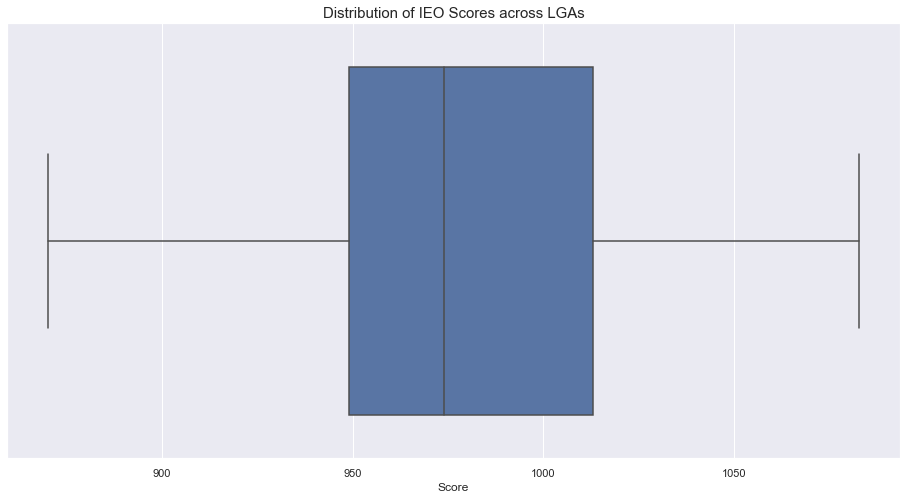

In [136]:
plt.figure(figsize=(16,8))
sns.boxplot(x=sa_vouchers_scores['IEO'])
plt.xlabel("Score")
plt.ylabel("")
plt.title('Distribution of IEO Scores across LGAs', fontsize=15);

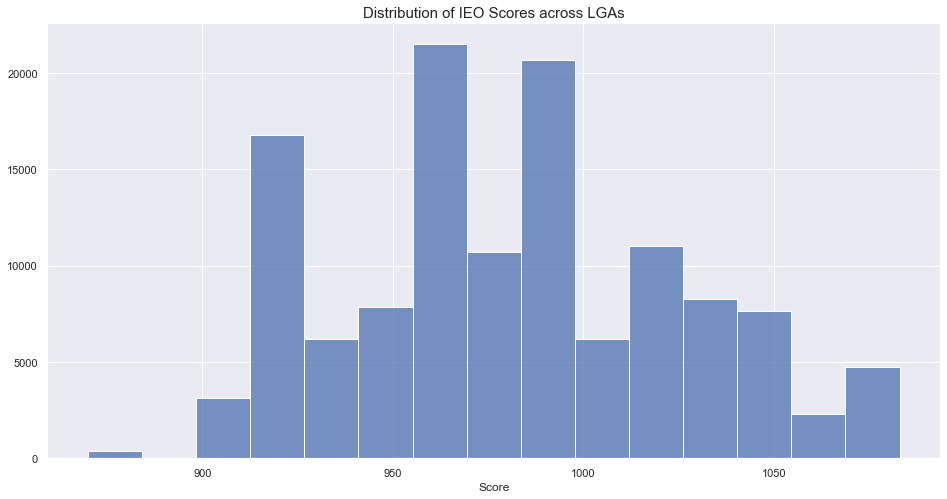

In [151]:
plt.figure(figsize=(16,8))
sns.histplot(x=sa_vouchers_scores['IEO'], bins=15)
plt.xlabel("Score")
plt.ylabel("")
plt.title('Distribution of IEO Scores across LGAs', fontsize=15);

For further analysis, the variable will be divided into tertiles as:
- 1: "low" 
- 2: "middle"
- 3: "high"

In [152]:
sa_master['IEO_Categorical'] = pd.cut(sa_master['IEO'], 3, labels=[1, # low
                                                                   2, # mid
                                                                   3]) # high
sa_master.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population,Not_ATSI,Not_Aboriginal,Australian,Male,IEO_Categorical
0,1000002,ABERFOYLE PARK,Registered Previously,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996,996,975,993,159517,1,1,1,1,2
1,1000002,ABERFOYLE PARK,Registered Previously,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996,996,975,993,159517,1,1,1,1,2
2,1000004,ABERFOYLE PARK,Not Registered Previously,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996,996,975,993,159517,1,1,1,0,2
3,1000004,ABERFOYLE PARK,Registered Previously,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996,996,975,993,159517,1,1,1,0,2
4,1000005,ABERFOYLE PARK,Registered Previously,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996,996,975,993,159517,1,1,1,0,2


### IER
--> The Index of Economic Resources (IER) focuses on the financial aspects of relative socio-economic advantage and disadvantage, by summarising variables related to income and wealth. This index excludes education and occupation variables because they are not direct measures of economic resources. It also misses some assets such as savings or equities which, although relevant, could not be included because this information was not collected in the 2011 Census.

In [153]:
sa_vouchers_scores['IER'].describe()

count    127526.000000
mean        980.843624
std          45.556407
min         870.000000
25%         949.000000
50%         974.000000
75%        1013.000000
max        1083.000000
Name: IER, dtype: float64

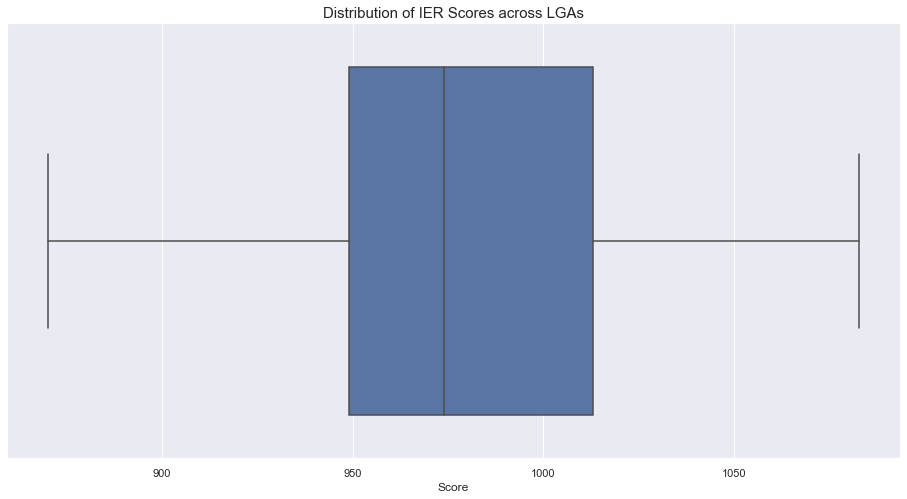

In [154]:
plt.figure(figsize=(16,8))
sns.boxplot(x=sa_vouchers_scores['IER'])
plt.xlabel("Score")
plt.ylabel("")
plt.title('Distribution of IER Scores across LGAs', fontsize=15);

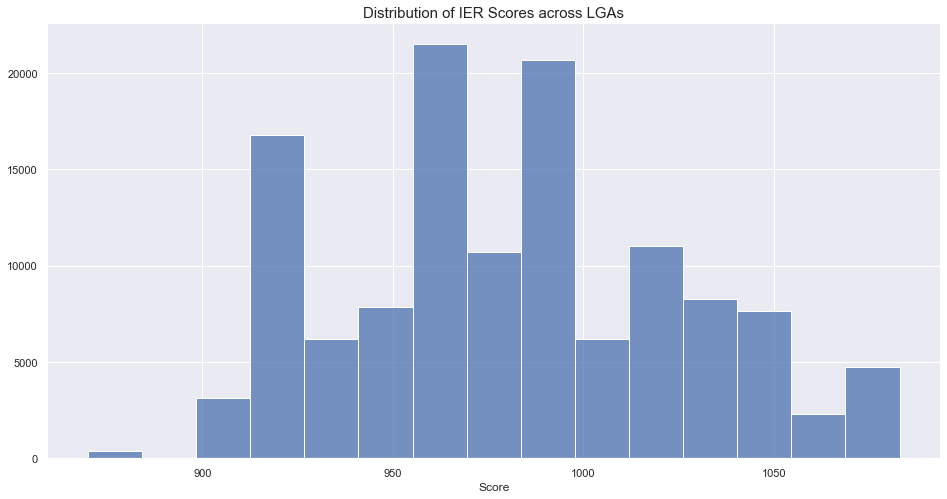

In [155]:
plt.figure(figsize=(16,8))
sns.histplot(x=sa_vouchers_scores['IER'], bins=15)
plt.xlabel("Score")
plt.ylabel("")
plt.title('Distribution of IER Scores across LGAs', fontsize=15);

For further analysis, the variable will be divided into tertiles as:
- 1: "low" 
- 2: "middle"
- 3: "high"

In [156]:
sa_master['IER_Categorical'] = pd.cut(sa_master['IER'], 3, labels=[1, # low
                                                                   2, # mid
                                                                   3]) # high
sa_master.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,...,IER,IRSAD,IRSD,Population,Not_ATSI,Not_Aboriginal,Australian,Male,IEO_Categorical,IER_Categorical
0,1000002,ABERFOYLE PARK,Registered Previously,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,...,996,975,993,159517,1,1,1,1,2,2
1,1000002,ABERFOYLE PARK,Registered Previously,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,...,996,975,993,159517,1,1,1,1,2,2
2,1000004,ABERFOYLE PARK,Not Registered Previously,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,...,996,975,993,159517,1,1,1,0,2,2
3,1000004,ABERFOYLE PARK,Registered Previously,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,...,996,975,993,159517,1,1,1,0,2,2
4,1000005,ABERFOYLE PARK,Registered Previously,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,...,996,975,993,159517,1,1,1,0,2,2


### IRSAD
--> The Index of Relative Socio-economic Advantage and Disadvantage (IRSAD) summarises information about the economic and social conditions of people and households within an area, including both relative advantage and disadvantage measures.

In [159]:
sa_vouchers_scores['IRSAD'].describe()

count    127526.000000
mean        970.382408
std          57.200547
min         808.000000
25%         926.000000
50%         975.000000
75%        1010.000000
max        1090.000000
Name: IRSAD, dtype: float64

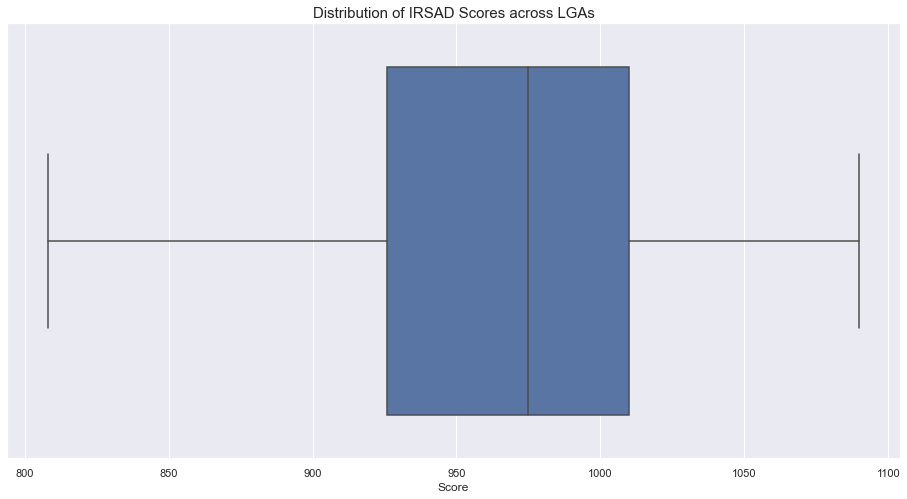

In [160]:
plt.figure(figsize=(16,8))
sns.boxplot(x=sa_vouchers_scores['IRSAD'])
plt.xlabel("Score")
plt.ylabel("")
plt.title('Distribution of IRSAD Scores across LGAs', fontsize=15);

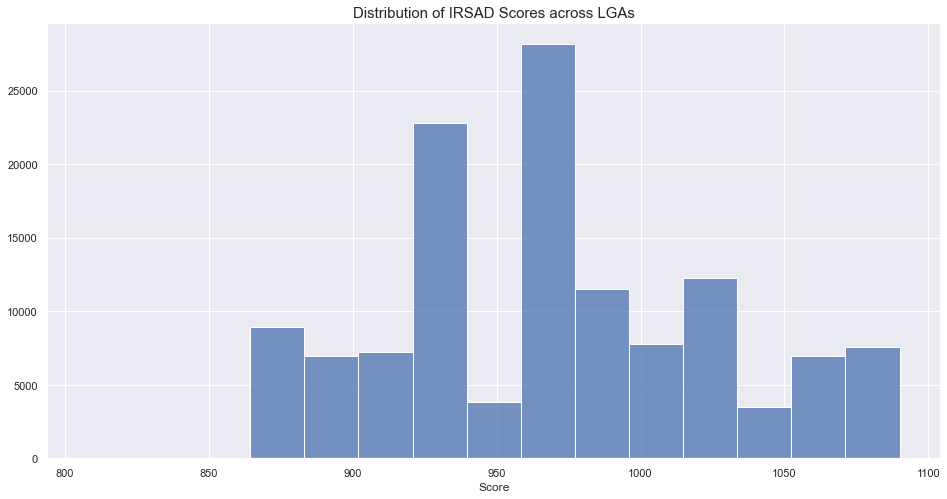

In [161]:
plt.figure(figsize=(16,8))
sns.histplot(x=sa_vouchers_scores['IRSAD'], bins=15)
plt.xlabel("Score")
plt.ylabel("")
plt.title('Distribution of IRSAD Scores across LGAs', fontsize=15);

For further analysis, the variable will be divided into tertiles as:
- 1: "low" 
- 2: "middle"
- 3: "high"

In [162]:
sa_master['IRSAD_Categorical'] = pd.cut(sa_master['IRSAD'], 3, labels=[1, # low
                                                                   2, # mid
                                                                   3]) # high
sa_master.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,...,IRSAD,IRSD,Population,Not_ATSI,Not_Aboriginal,Australian,Male,IEO_Categorical,IER_Categorical,IRSAD_Categorical
0,1000002,ABERFOYLE PARK,Registered Previously,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,...,975,993,159517,1,1,1,1,2,2,2
1,1000002,ABERFOYLE PARK,Registered Previously,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,...,975,993,159517,1,1,1,1,2,2,2
2,1000004,ABERFOYLE PARK,Not Registered Previously,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,...,975,993,159517,1,1,1,0,2,2,2
3,1000004,ABERFOYLE PARK,Registered Previously,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,...,975,993,159517,1,1,1,0,2,2,2
4,1000005,ABERFOYLE PARK,Registered Previously,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,...,975,993,159517,1,1,1,0,2,2,2


### IRSD
--> The Index of Relative Socio-economic Disadvantage (IRSD) is a general socio-economic index that summarises a range of information about the economic and social conditions of people and households within an area.


In [163]:
sa_vouchers_scores['IRSD'].describe()

count    127526.000000
mean        981.098968
std          55.951106
min         798.000000
25%         937.000000
50%         993.000000
75%        1025.000000
max        1096.000000
Name: IRSD, dtype: float64

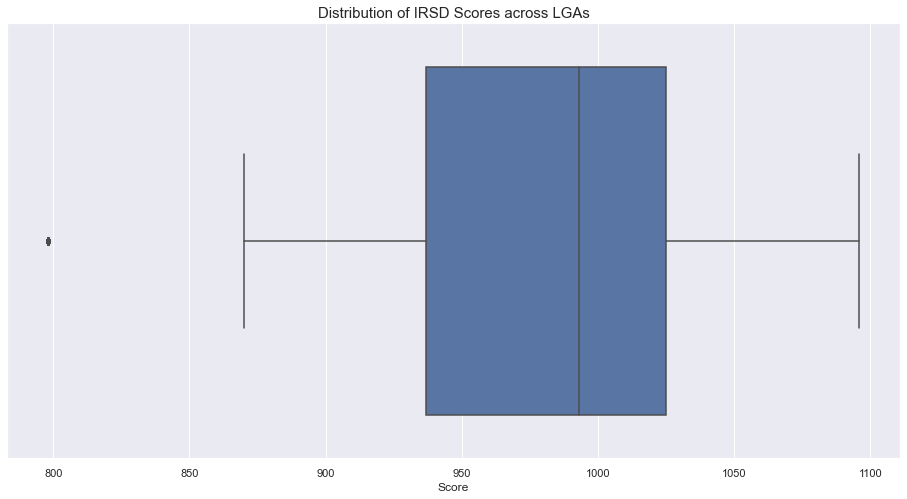

In [164]:
plt.figure(figsize=(16,8))
sns.boxplot(x=sa_vouchers_scores['IRSD'])
plt.xlabel("Score")
plt.ylabel("")
plt.title('Distribution of IRSD Scores across LGAs', fontsize=15);

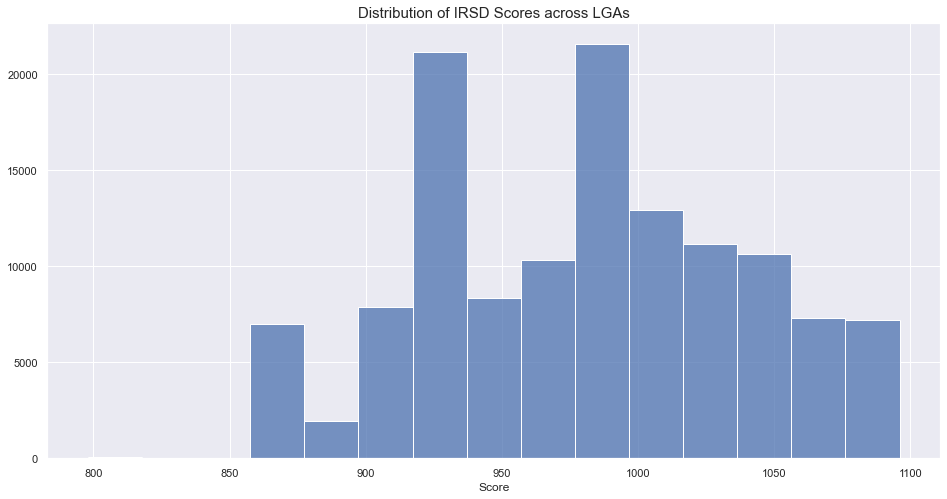

In [165]:
plt.figure(figsize=(16,8))
sns.histplot(x=sa_vouchers_scores['IRSD'], bins=15)
plt.xlabel("Score")
plt.ylabel("")
plt.title('Distribution of IRSD Scores across LGAs', fontsize=15);

For further analysis, the variable will be divided into tertiles as:
- 1: "low" 
- 2: "middle"
- 3: "high"

In [166]:
sa_master['IRSD_Categorical'] = pd.cut(sa_master['IRSD'], 3, labels=[1, # low
                                                                   2, # mid
                                                                   3]) # high
sa_master.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,...,IRSD,Population,Not_ATSI,Not_Aboriginal,Australian,Male,IEO_Categorical,IER_Categorical,IRSAD_Categorical,IRSD_Categorical
0,1000002,ABERFOYLE PARK,Registered Previously,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,...,993,159517,1,1,1,1,2,2,2,2
1,1000002,ABERFOYLE PARK,Registered Previously,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,...,993,159517,1,1,1,1,2,2,2,2
2,1000004,ABERFOYLE PARK,Not Registered Previously,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,...,993,159517,1,1,1,0,2,2,2,2
3,1000004,ABERFOYLE PARK,Registered Previously,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,...,993,159517,1,1,1,0,2,2,2,2
4,1000005,ABERFOYLE PARK,Registered Previously,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,...,993,159517,1,1,1,0,2,2,2,2


## Conduct bivariate analysis of variables with target variable

In [170]:
# remove unneeded columns
sa_master_trim = sa_master.drop(["Participant_Suburb", 
                                 "Club_Previous_Member", 
                                 "Voucher_Value", 
                                 "Club_Name", 
                                 "Voucher_Sport", 
                                 "Participant_Electorate", 
                                 "Voucher_Completion_Date"], 
                               axis=1)
sa_master_trim

,Participant_ID,Participant_LGA,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population,Not_ATSI,Not_Aboriginal,Australian,Male,IEO_Categorical,IER_Categorical,IRSAD_Categorical,IRSD_Categorical
0,1000002,ONKAPARINGA,2015,996,996,975,993,159517,1,1,1,1,2,2,2,2
1,1000002,ONKAPARINGA,2016,996,996,975,993,159517,1,1,1,1,2,2,2,2
2,1000004,ONKAPARINGA,2016,996,996,975,993,159517,1,1,1,0,2,2,2,2
3,1000004,ONKAPARINGA,2017,996,996,975,993,159517,1,1,1,0,2,2,2,2
4,1000005,ONKAPARINGA,2015,996,996,975,993,159517,1,1,1,0,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127521,1127524,MID MURRAY,2016,965,965,917,937,8134,1,1,1,0,2,2,2,2
127522,1127524,MID MURRAY,2015,965,965,917,937,8134,1,1,1,0,2,2,2,2
127523,1127524,MID MURRAY,2017,965,965,917,937,8134,1,1,1,0,2,2,2,2
127524,1127526,MID MURRAY,2015,965,965,917,937,8134,1,1,1,0,2,2,2,2


# Challenge - Queensland

_Note: this is an extra task that you might take on to get a better grade for your portfolio.  You can get a good pass grade without doing this._ 

Queensland has a similar program called [Get Started](https://data.gov.au/dataset/ds-qld-3118838a-d425-48fa-bfc9-bc615ddae44e/details?q=get%20started%20vouchers) and we can retrieve data from their program in a similar format.  

The file [round1-redeemed_get_started_vouchers.csv](files/round1-redeemed_get_started_vouchers.csv) contains records of the vouchers issued in Queensland. The date of this data is not included but the program started in 2015 so it is probably from around then.  

The data includes the LGA of the individual but the name of the activity is slightly different.  To do a comparable analysis you would need to map the activity names onto those from South Australia. 

In [82]:
qld_vouchers = pd.read_csv('files/round1-redeemed_get_started_vouchers.csv')
qld_vouchers.head()

,Application Number,Voucher Number,Child Age (at time of Application),Gender,Has your child played sport before?,Participation Activity,Club Name,Club Suburb/Town,Club Local Government Area Name,Club State Electoral District Name,Parent Suburb/Town,Total Payment
0,2000012253,Q89QDUXP,10,NaN,Yes,*Other,Queensland Police-Citizens Youth Welfare Assoc...,Airlie Beach,Whitsunday (R),Whitsunday,Jubilee Pocket,60.01
1,2000001727,593F6Y41,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Leichhardt,150.00
2,2000013464,PH2R4RTT,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Woodridge,150.00
3,2000009270,035SE2H5,5,NaN,Yes,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Yatala,150.00
4,2000007273,NP6C4729,6,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Alexandra Hills,150.00


In [83]:
# Join the QLD data with the LGA data as before to get population and SIEFA data integrated
qld_vouchers['LGA'] = qld_vouchers['Club Local Government Area Name'].str.replace(' \([RC]+\)', '').str.upper()
qld_vouchers_scores = qld_vouchers.join(LGA_scores, on='LGA')
qld_vouchers_scores.head()

/var/folders/31/2xxsfpps75923jkzs3xks1w00000gq/T/ipykernel_17916/1542685289.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  qld_vouchers['LGA'] = qld_vouchers['Club Local Government Area Name'].str.replace(' \([RC]+\)', '').str.upper()


,Application Number,Voucher Number,Child Age (at time of Application),Gender,Has your child played sport before?,Participation Activity,Club Name,Club Suburb/Town,Club Local Government Area Name,Club State Electoral District Name,Parent Suburb/Town,Total Payment,LGA,IEO,IER,IRSAD,IRSD,Population,Voucher_Per_100
0,2000012253,Q89QDUXP,10,NaN,Yes,*Other,Queensland Police-Citizens Youth Welfare Assoc...,Airlie Beach,Whitsunday (R),Whitsunday,Jubilee Pocket,60.01,WHITSUNDAY,NaN,NaN,NaN,NaN,NaN,NaN
1,2000001727,593F6Y41,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Leichhardt,150.00,BRISBANE,NaN,NaN,NaN,NaN,NaN,NaN
2,2000013464,PH2R4RTT,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Woodridge,150.00,BRISBANE,NaN,NaN,NaN,NaN,NaN,NaN
3,2000009270,035SE2H5,5,NaN,Yes,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Yatala,150.00,BRISBANE,NaN,NaN,NaN,NaN,NaN,NaN
4,2000007273,NP6C4729,6,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Alexandra Hills,150.00,BRISBANE,NaN,NaN,NaN,NaN,NaN,NaN
